In [1]:
import warnings
import ast
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

warnings.filterwarnings("ignore")

In [2]:
PROJECT_NAME = "flink"
EXP_ID = "apch"
MODEL_HISTORY = 15
TOTAL_WINDOWS = 54
ALPHA = 0.05

DATA_DIR = Path().cwd() / "ecoselekt" / "data"
MODELS_DIR = Path().cwd() / "ecoselekt" / "models"
RESULTS_DIR = Path().cwd() / "results" / f"exp_{EXP_ID}"
FIGURES_DIR = Path().cwd() / "figures"

DATA_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
# load baseline evaluation results
base_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_base_eval.csv")
base_eval_df["model"] = "base"
base_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,flink,0,1,0.0,0.0,0.0,0.974874,0.0,0.166667,1.000000,base
1,flink,0,2,0.0,0.0,0.0,-1.000000,1.0,-0.000000,0.000000,base
2,flink,0,3,0.0,0.0,0.0,0.916667,0.0,0.105263,1.000000,base
3,flink,0,4,0.0,0.0,0.0,0.928219,0.0,0.542448,0.994652,base
4,flink,0,5,0.0,0.0,0.0,0.181895,0.0,0.012469,1.000000,base


In [4]:
# load ecoselekt evaluation results
selekt_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_selekt_eval.csv")
selekt_eval_df["model"] = "ecoselekt"
selekt_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,flink,15,16,0.790123,0.719101,0.752941,0.857880,0.780364,0.839824,0.846847,ecoselekt
1,flink,15,17,0.896552,0.696429,0.783920,0.837764,0.790698,0.869216,0.897727,ecoselekt
2,flink,15,18,0.876712,0.592593,0.707182,0.817935,0.731178,0.847451,0.902174,ecoselekt
3,flink,15,19,0.779070,0.626168,0.694301,0.803939,0.705862,0.809833,0.795699,ecoselekt
4,flink,15,20,0.650000,0.553191,0.597701,0.737354,0.638017,0.717373,0.735849,ecoselekt


In [5]:
# load best select evaluation results
best_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_best_eval.csv")
best_eval_df["model"] = "best"
best_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,flink,15,16,0.893333,0.752809,0.817073,0.911934,0.835795,0.898474,0.927928,best
1,flink,15,17,0.963855,0.714286,0.820513,0.893669,0.830623,0.919458,0.965909,best
2,flink,15,18,0.896104,0.638889,0.745946,0.875604,0.763763,0.890721,0.913043,best
3,flink,15,19,0.875000,0.654206,0.748663,0.881469,0.764108,0.889769,0.892473,best
4,flink,15,20,0.703704,0.606383,0.651429,0.798725,0.684901,0.787798,0.773585,best


(1482, 11)


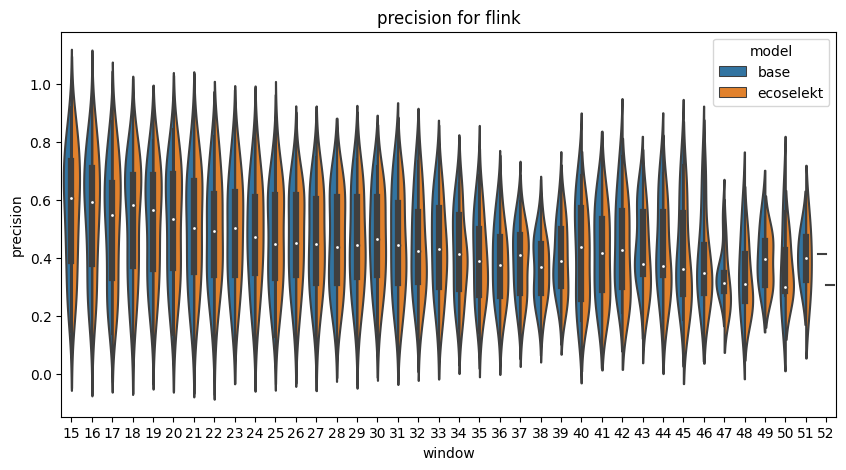

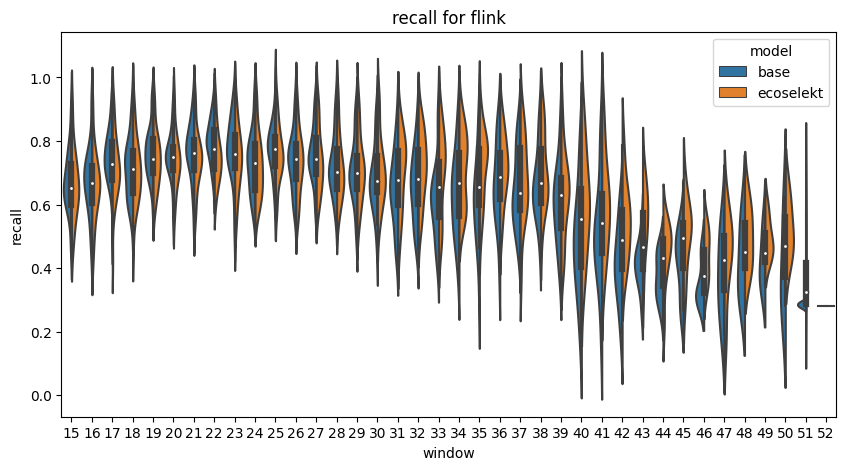

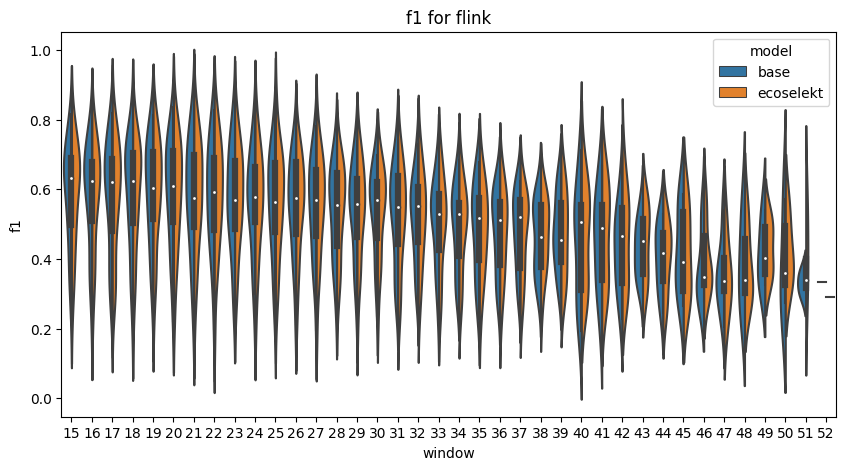

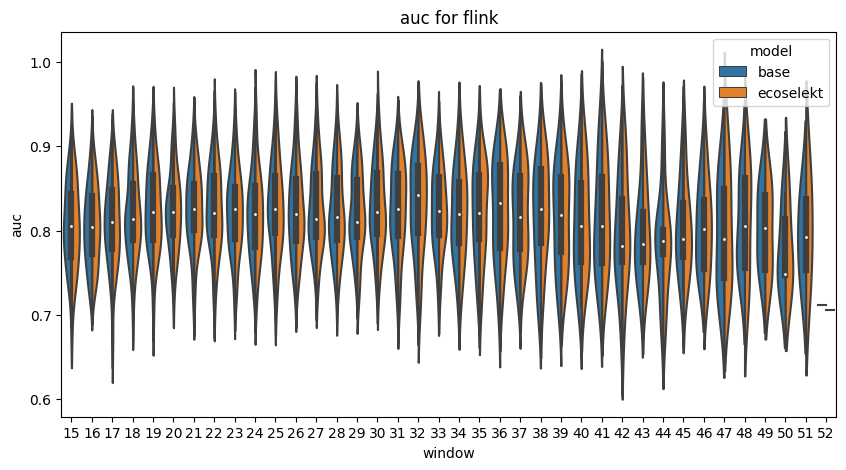

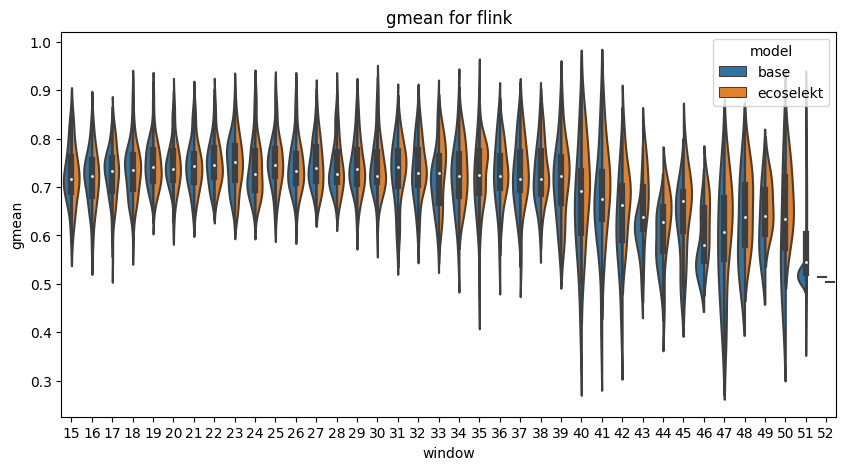

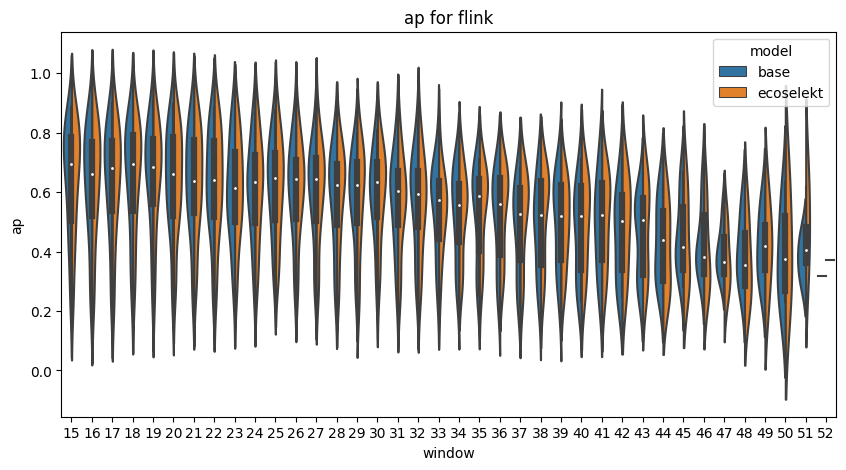

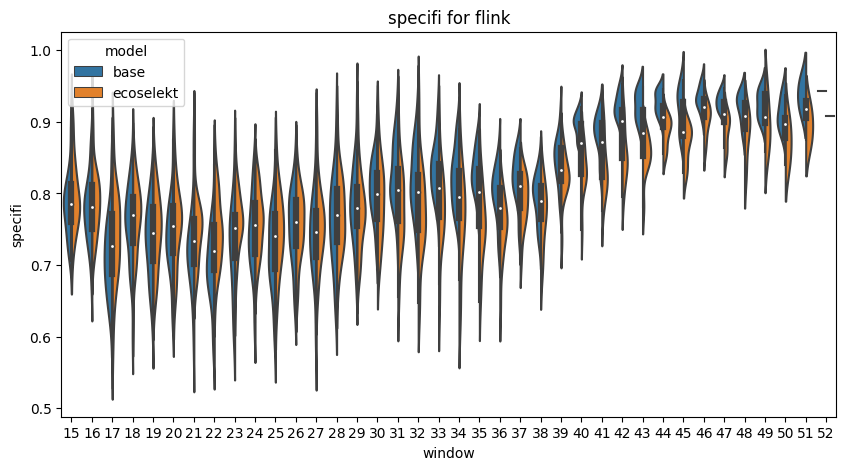

In [6]:
# concat base and ecoselekt evaluation dataframes keeping only common `window` and `test_split` then plot violin plots for each metric
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
print(eval_df.shape)

# plot violin plots for each metric
for metric in ["precision", "recall", "f1", "auc", "gmean", "ap", "specifi"]:
    plt.figure(figsize=(10, 5))
    sns.violinplot(x="window", y=metric, data=eval_df, hue="model", split=True)
    plt.title(f"{metric} for {PROJECT_NAME}")
    plt.show()


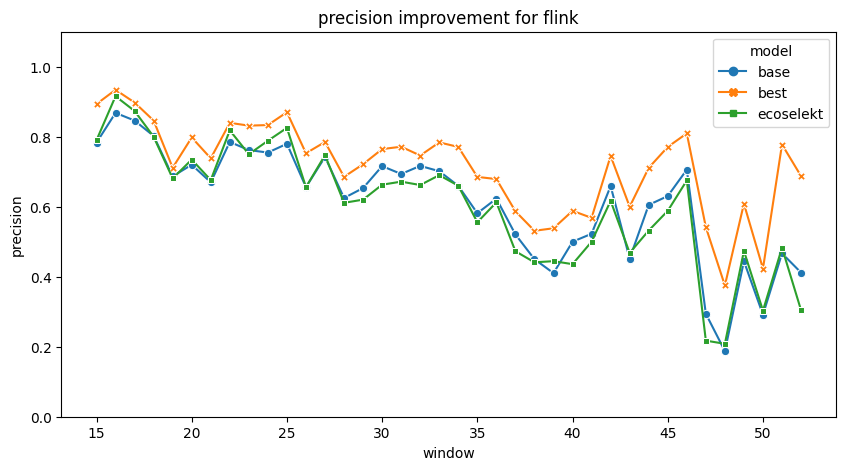

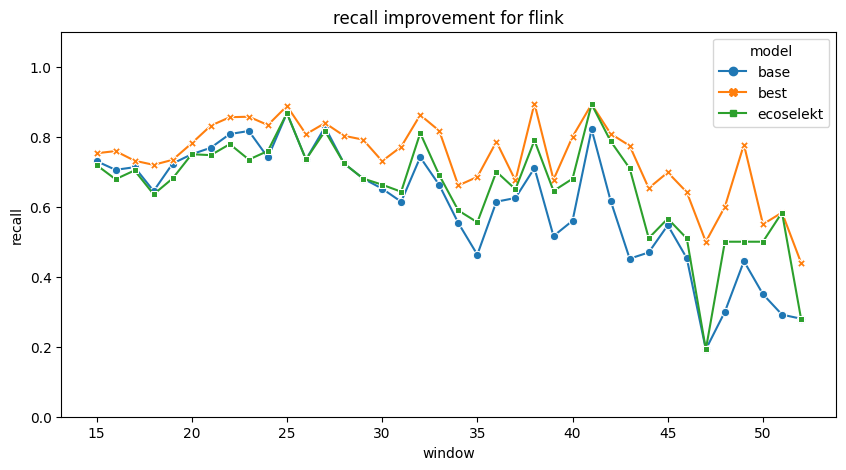

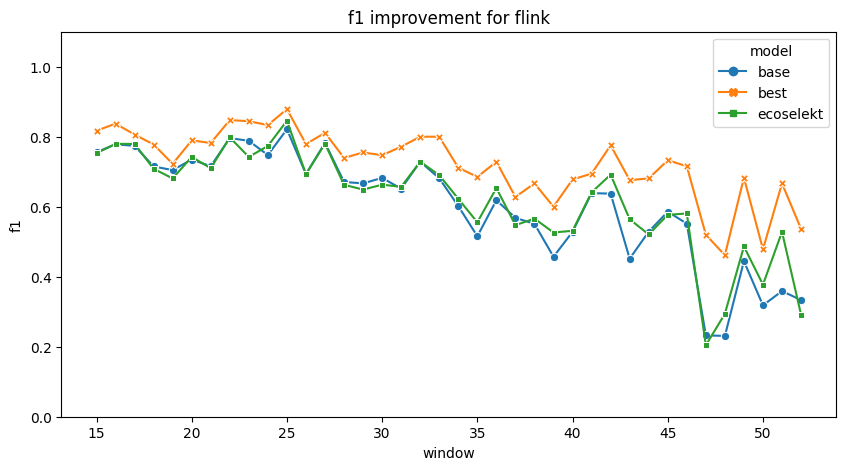

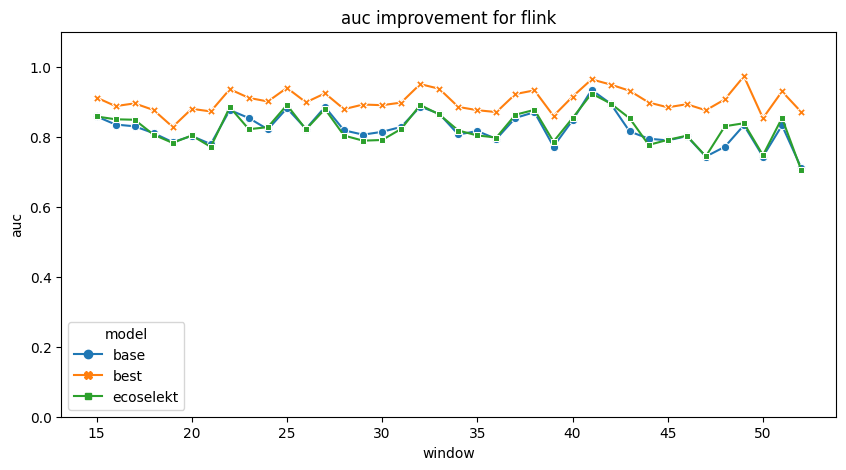

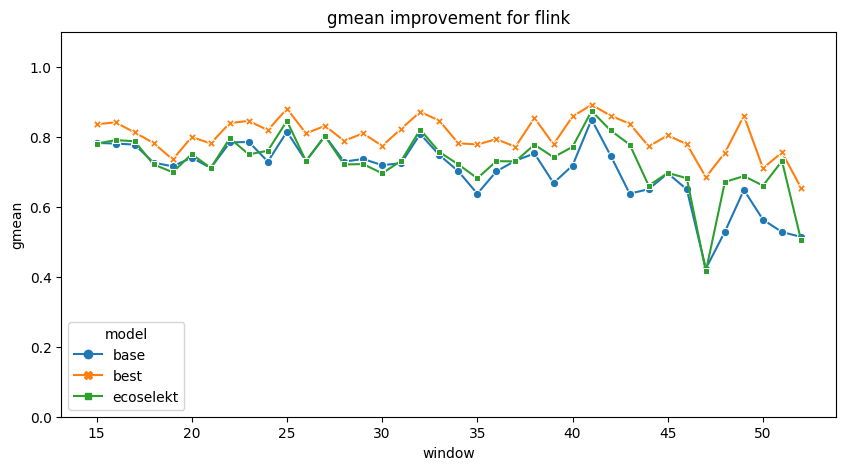

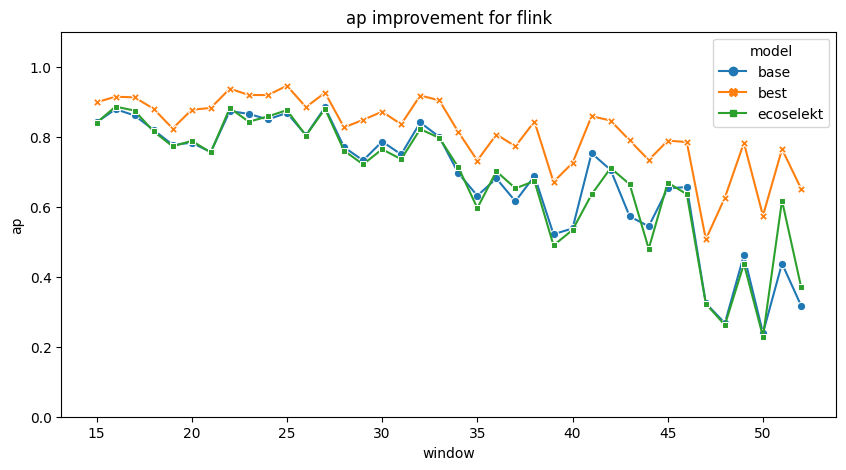

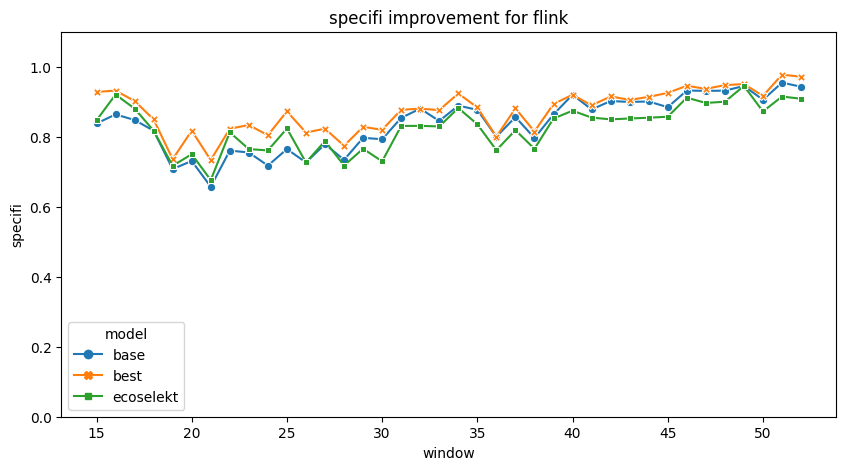

In [7]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], best_eval_df, selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
# plot percetange improvement for each metric for each window
for metric in ["precision", "recall", "f1", "auc", "gmean", "ap", "specifi"]:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x="window", y=metric, data=eval_df, hue="model", markers=True, style="model", dashes=False)
    plt.title(f"{metric} improvement for {PROJECT_NAME}")
    plt.ylim(0, 1.1)
    plt.show()

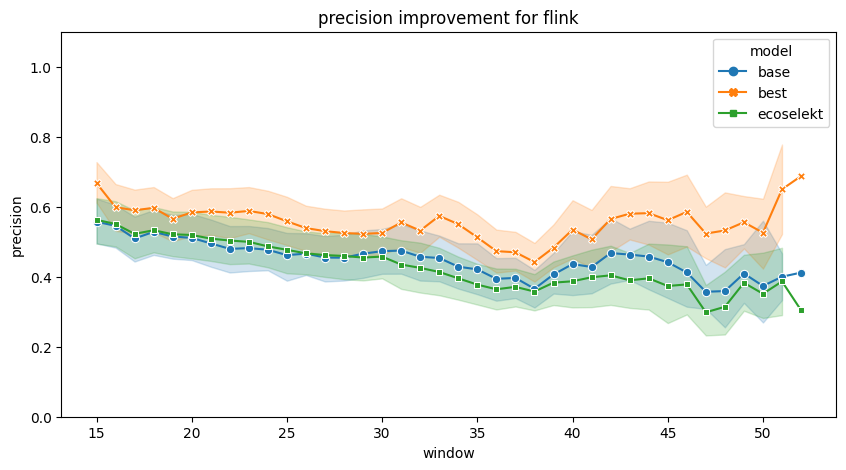

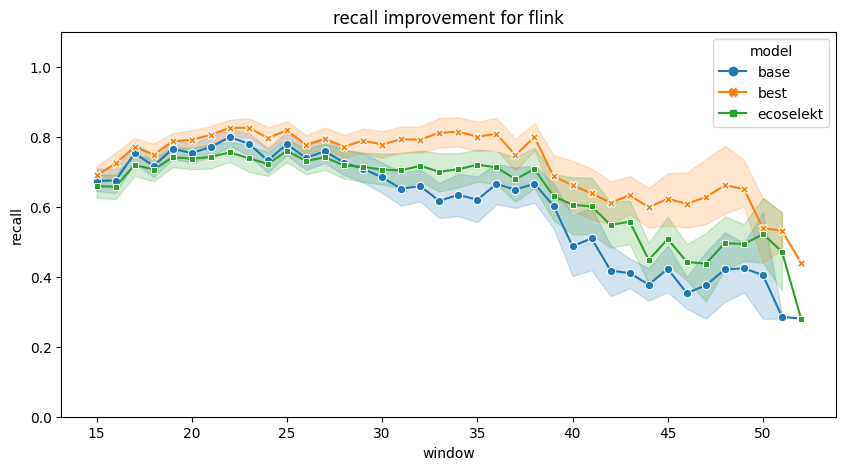

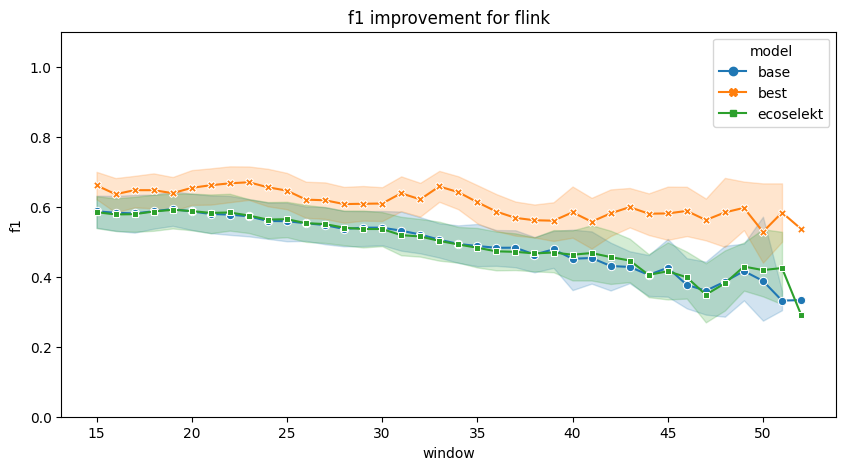

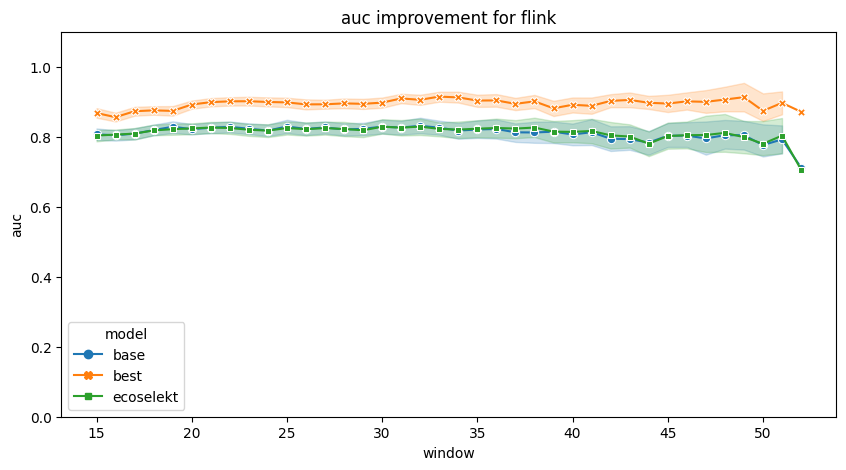

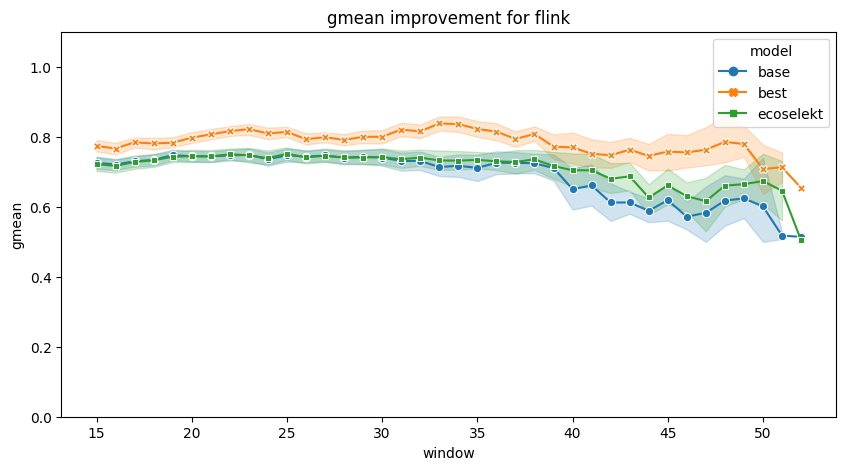

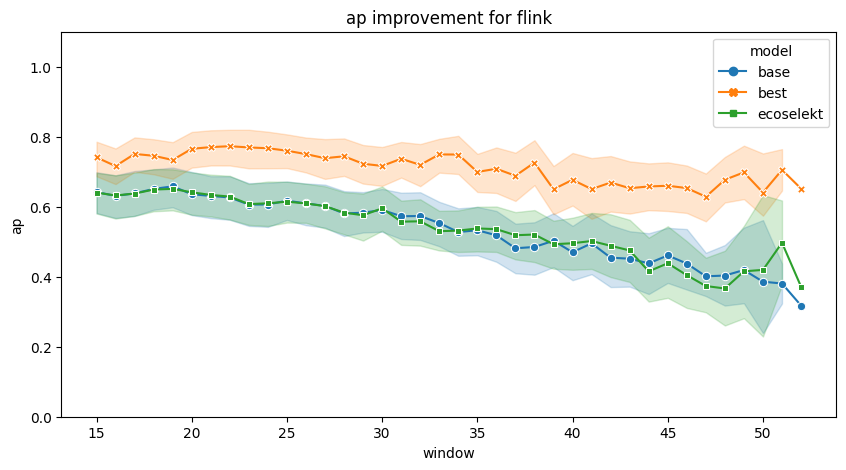

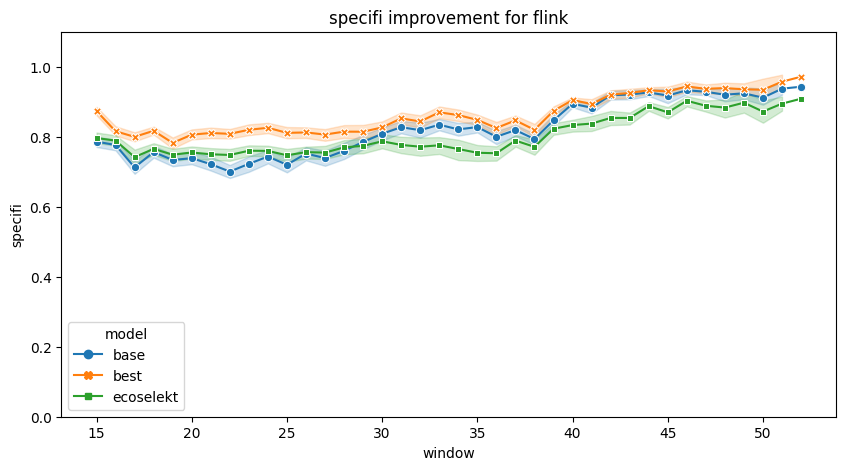

In [8]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], best_eval_df, selekt_eval_df])
# plot percetange improvement for each metric for each window
for metric in ["precision", "recall", "f1", "auc", "gmean", "ap", "specifi"]:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x="window", y=metric, data=eval_df, hue="model", markers=True, style="model", dashes=False)
    plt.title(f"{metric} improvement for {PROJECT_NAME}")
    plt.ylim(0, 1.1)
    plt.show()

In [9]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
_, p = wilcoxon(eval_df[eval_df["model"] == "ecoselekt"]["auc"], eval_df[eval_df["model"] == "base"]["auc"])
print(f"Wilcoxon test p-value: {p}")
print(f"Wilcoxon test significance: {p < ALPHA}")

Wilcoxon test p-value: 0.4727372199558886
Wilcoxon test significance: False


In [10]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
_, p = wilcoxon(eval_df[eval_df["model"] == "ecoselekt"]["recall"], eval_df[eval_df["model"] == "base"]["recall"])
print(f"Wilcoxon test p-value: {p}")
print(f"Wilcoxon test significance: {p < ALPHA}")

Wilcoxon test p-value: 0.001065544905170351
Wilcoxon test significance: True


In [11]:
bestmodel_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_best_model_per_test_split.csv")
bestmodel_df.drop(columns=["Unnamed: 0"], inplace=True)
print(bestmodel_df.shape)
bestmodel_df.head()

(148200, 4)


,commit_id,window,test_split,model_version
0,8f9d8ea9c0039e47bb4a82ce712c04d41e110fe6,15,16,14
1,f4d2ddabe51dad7bee2d4731782b2bdd549ccd20,15,16,15
2,935ad5a7a223c350b6d299ccee0a87cd1fa451de,15,16,15
3,383ae265c20b4f482f37a4d9b73ab2e54cf9c35e,15,16,14
4,405be09271de4a194696f0818e736a859e8edaf3,15,16,14


In [12]:
selektmodel_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_selected_model_per_test_split.csv")
selektmodel_df.drop(columns=["Unnamed: 0"], inplace=True)
print(selektmodel_df.shape)
selektmodel_df.head()

(148200, 4)


,commit_id,window,test_split,model_version
0,0190dd24622169a98be1a6ef518b0fdd018e2d44,15,16,15
1,024d744258697b28011836f78cd3a6a79d8281a8,15,16,15
2,0297d60c87aa029c24b10f2be4044cebe4c3300d,15,16,15
3,02e2857a94adc7e427f36180542196331e8ae871,15,16,15
4,034854db3eef60bc6247fabdc0172d2bc8c4496a,15,16,15


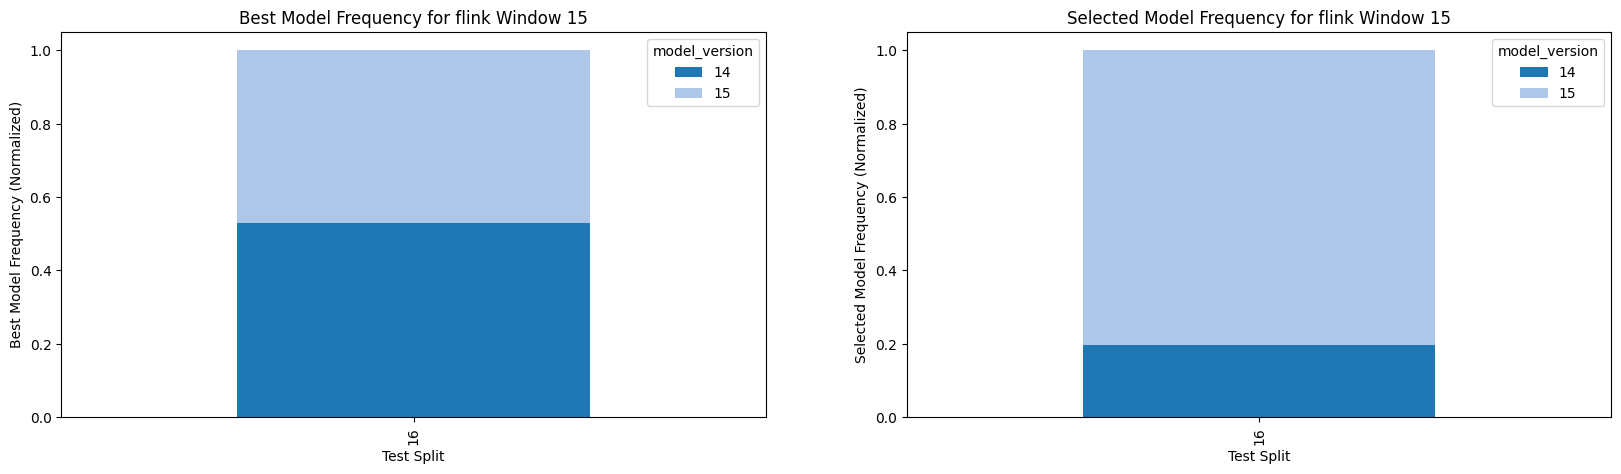

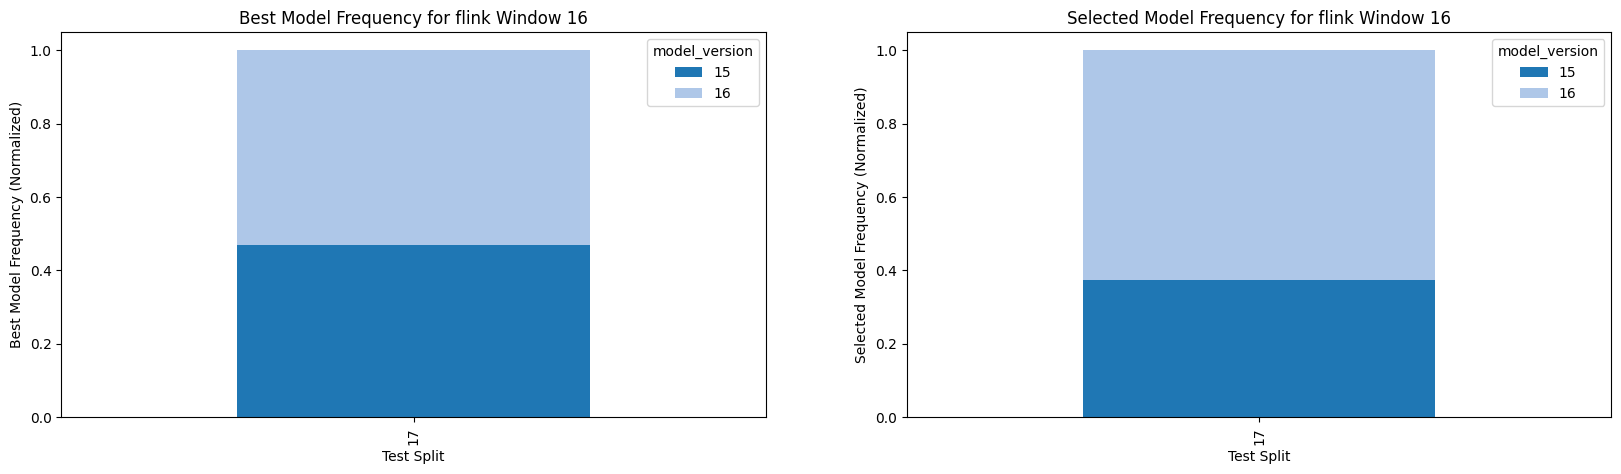

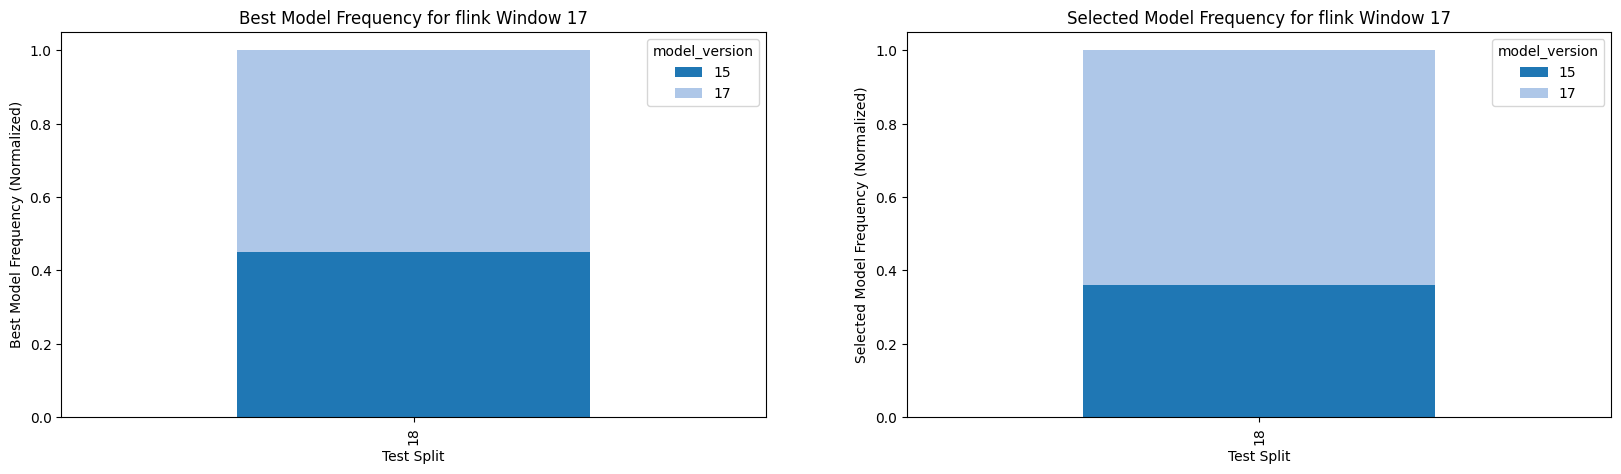

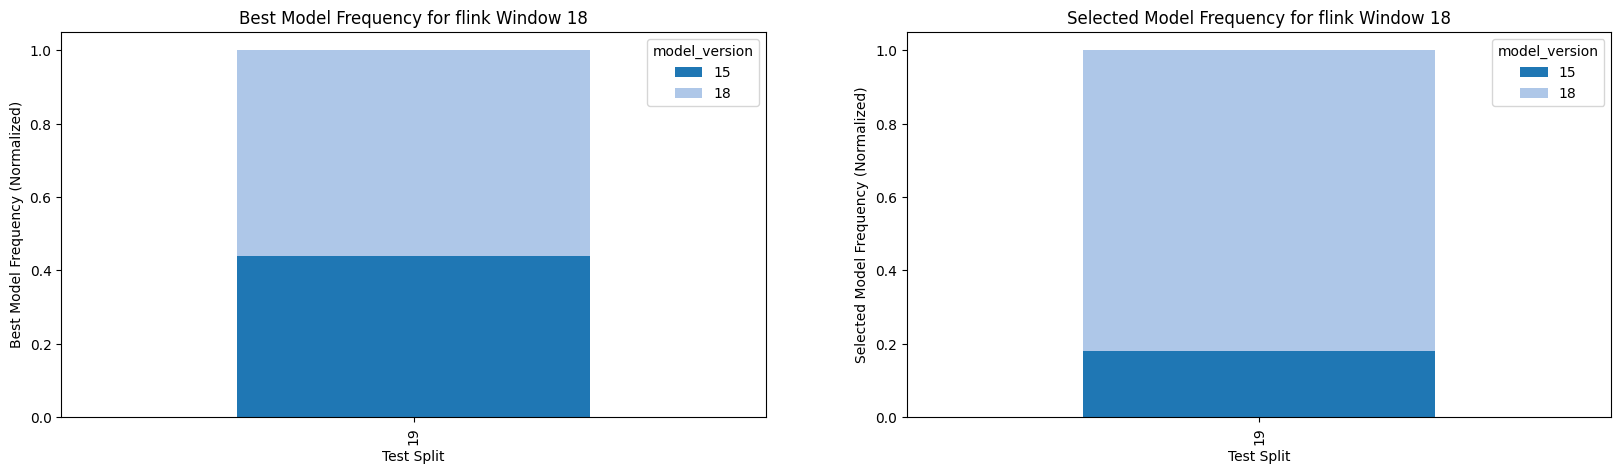

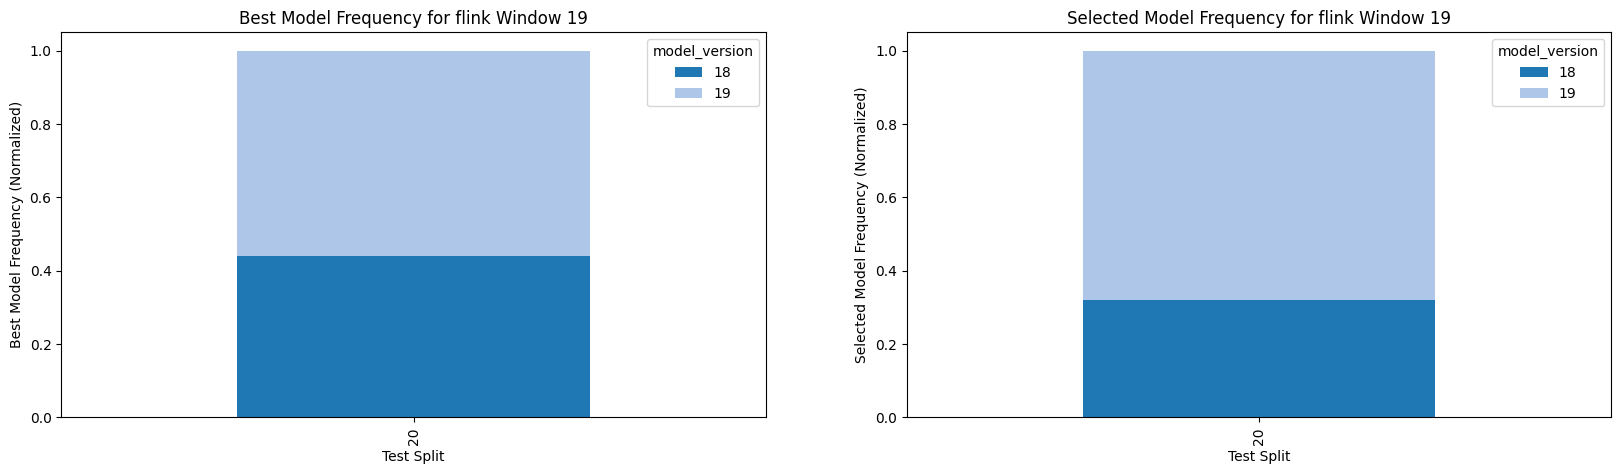

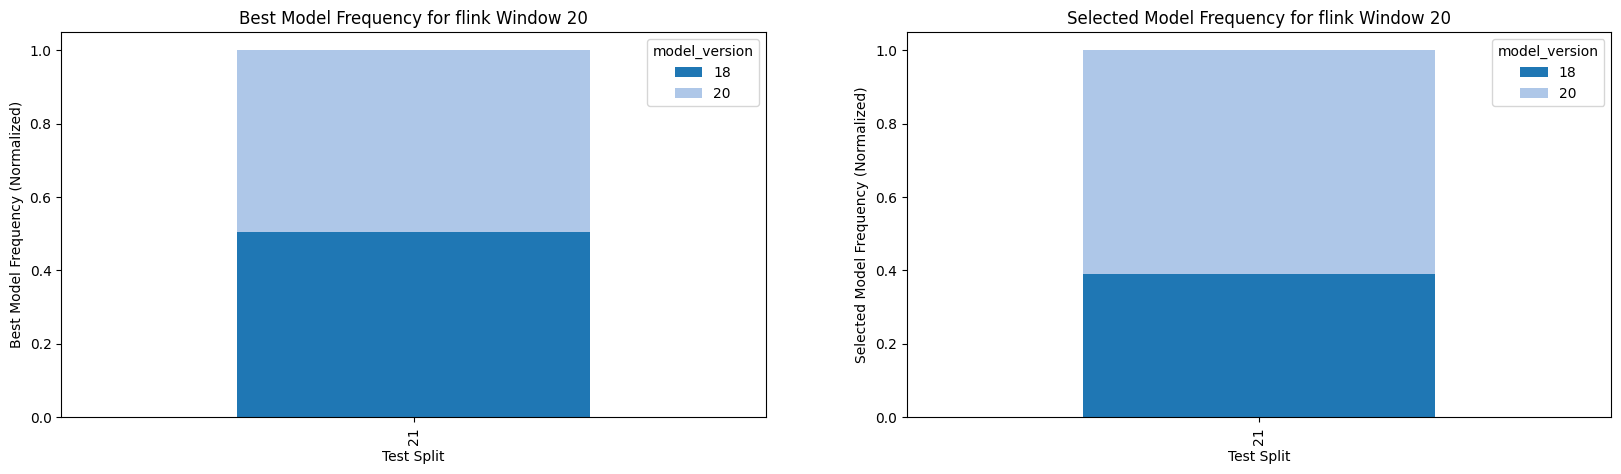

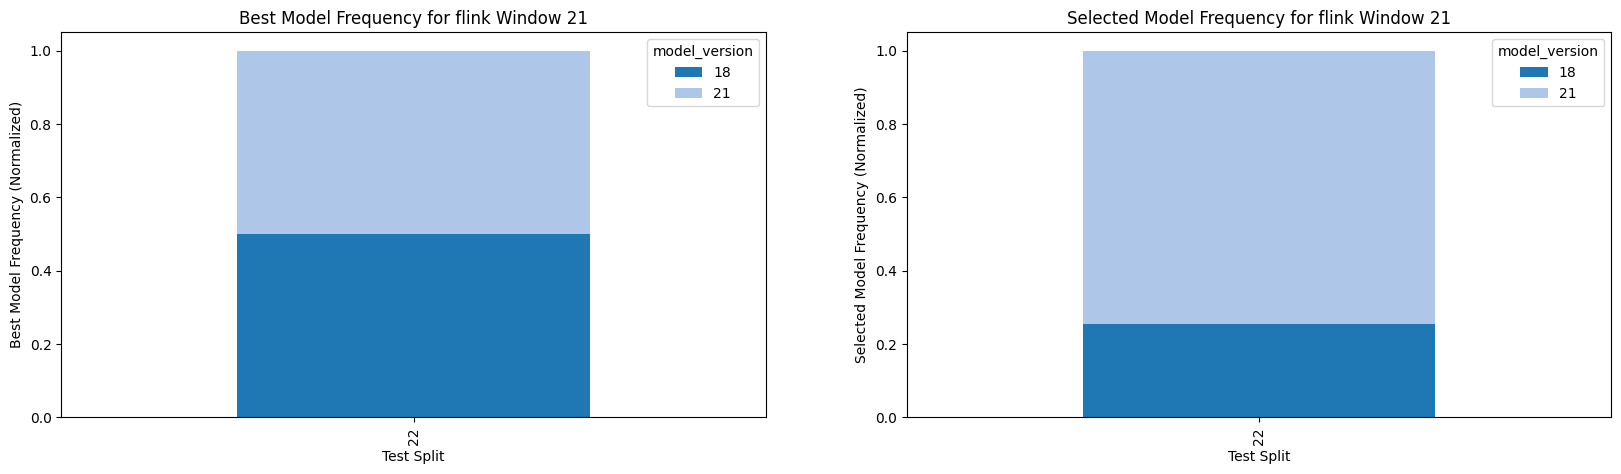

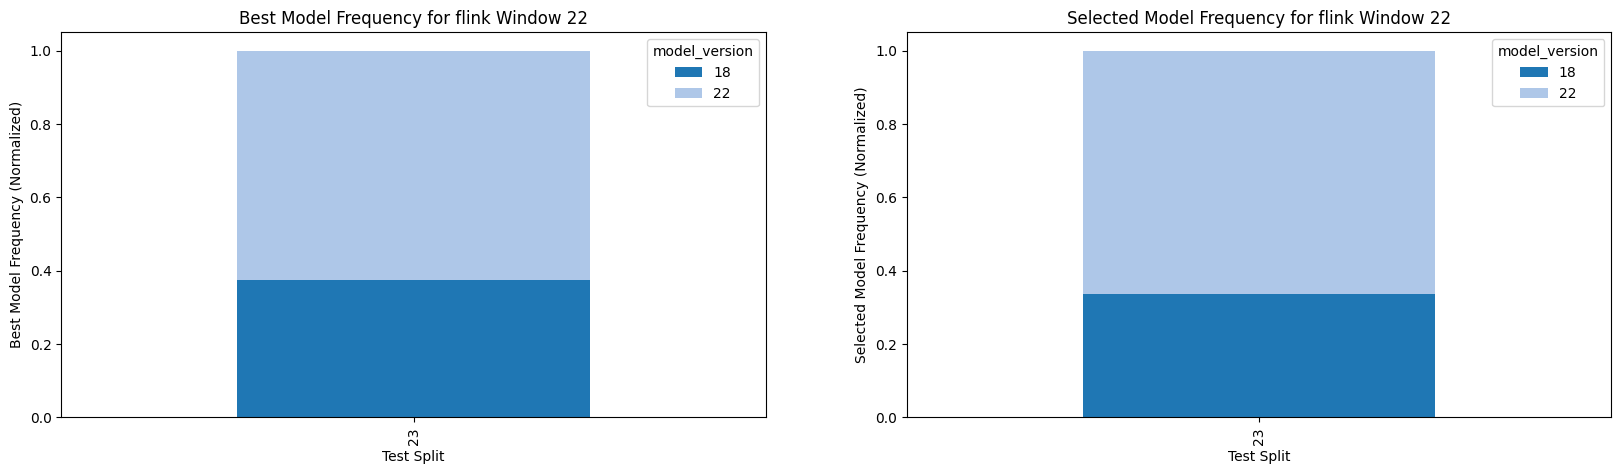

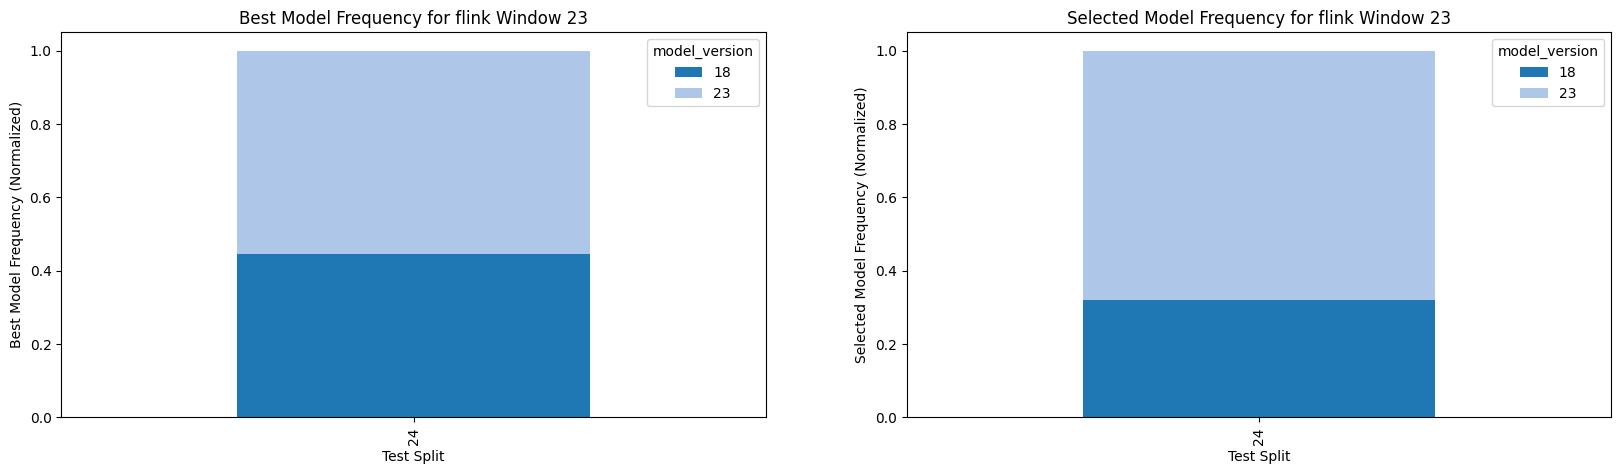

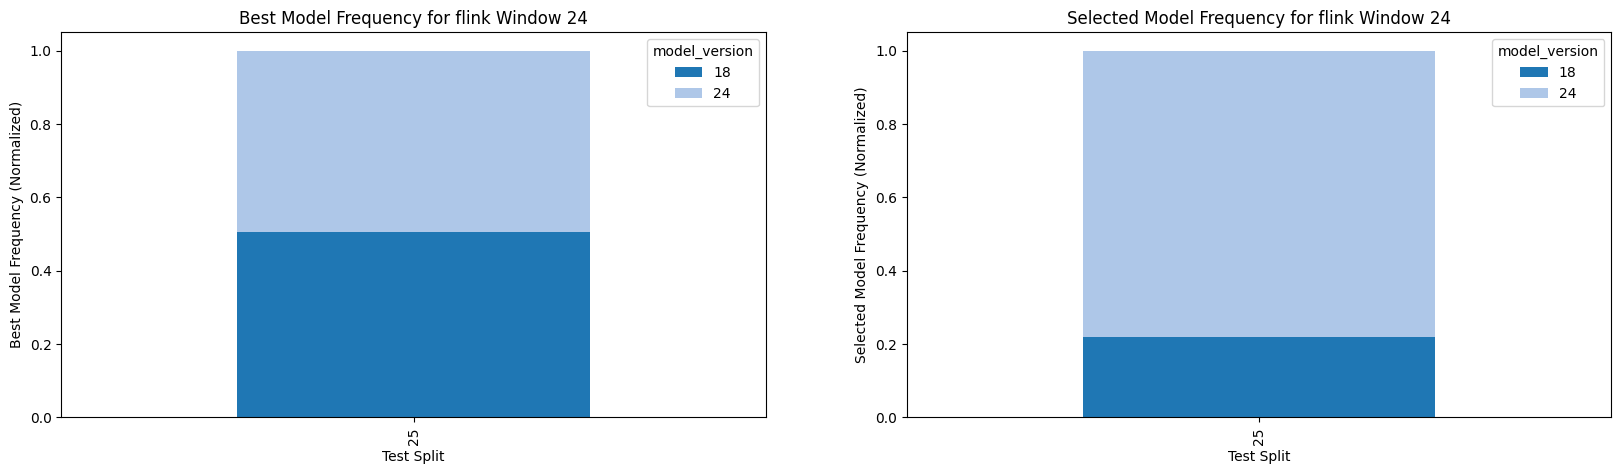

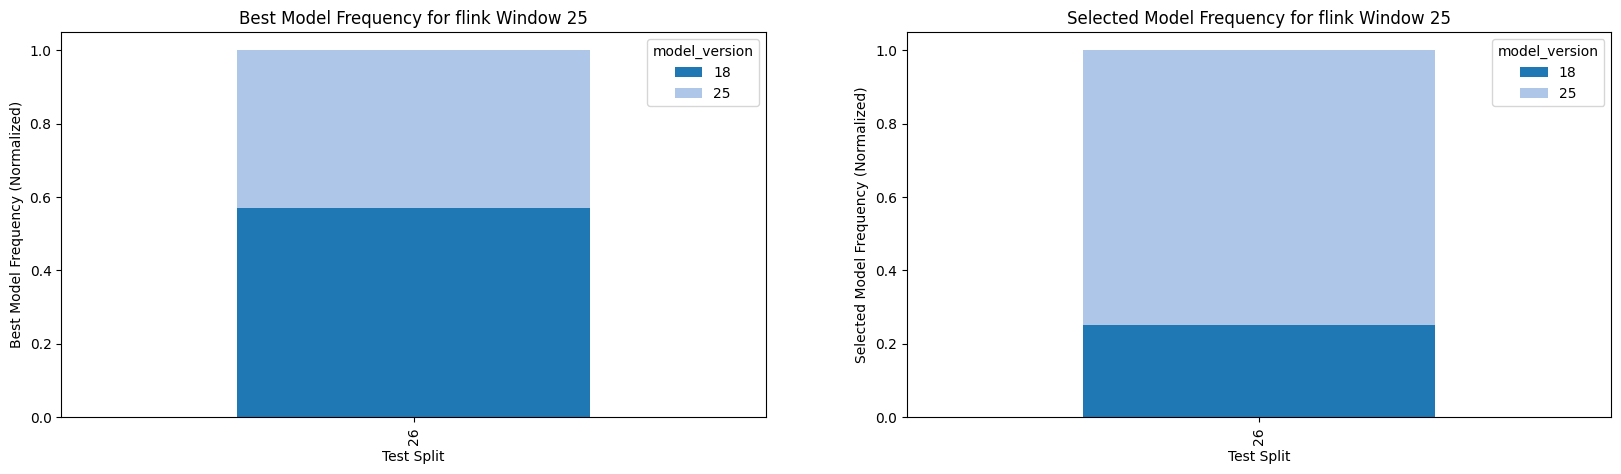

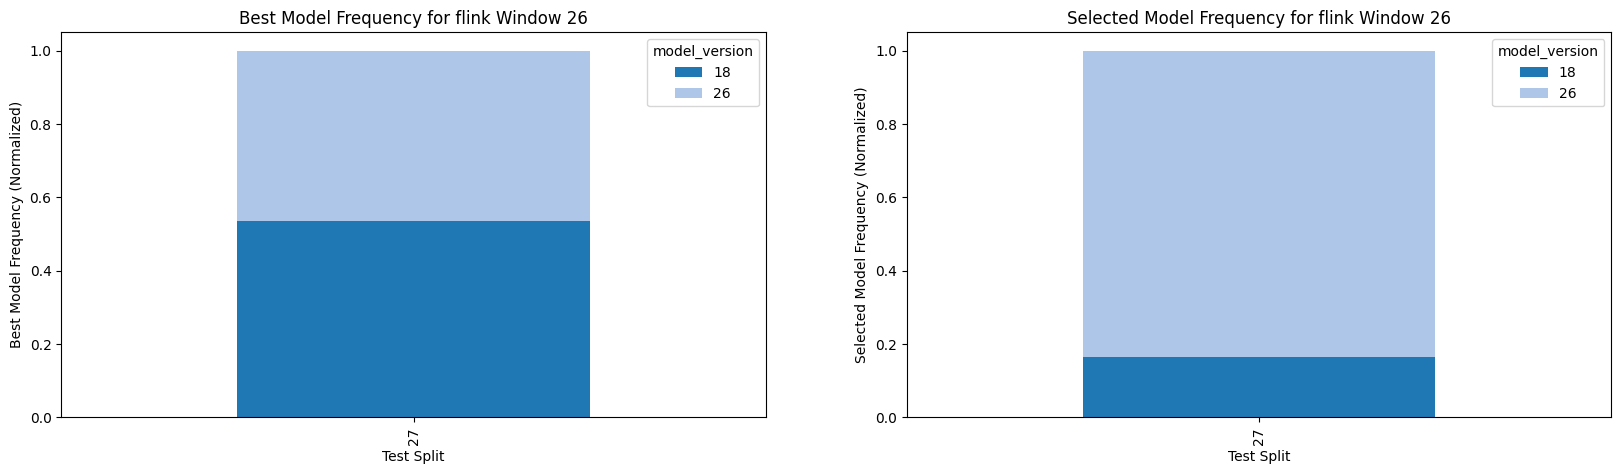

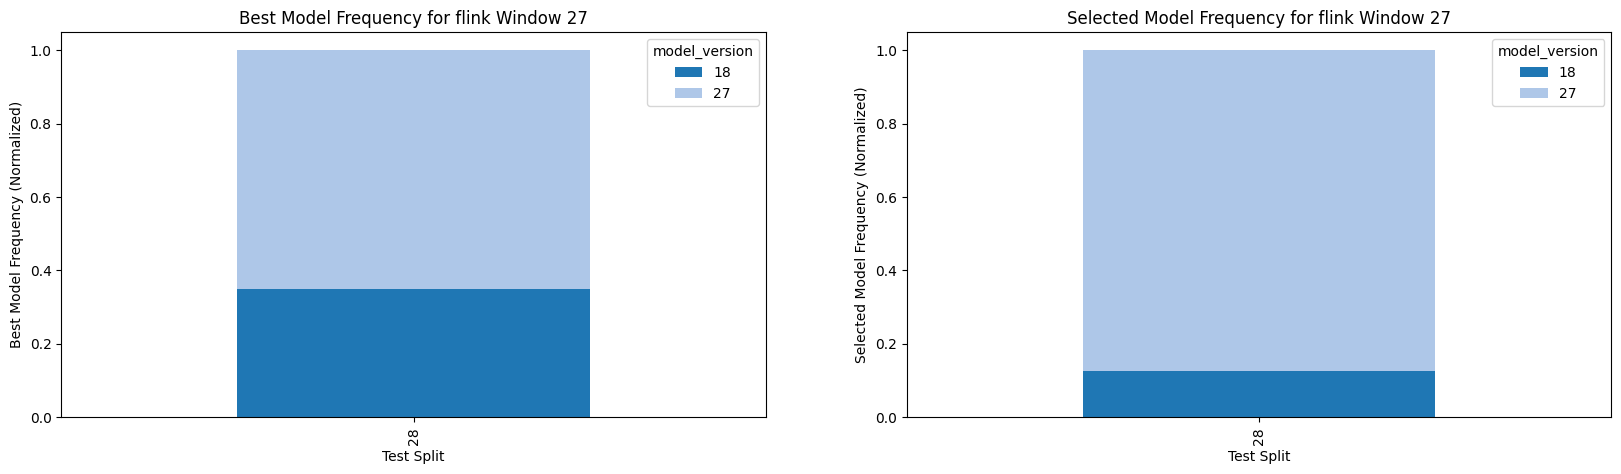

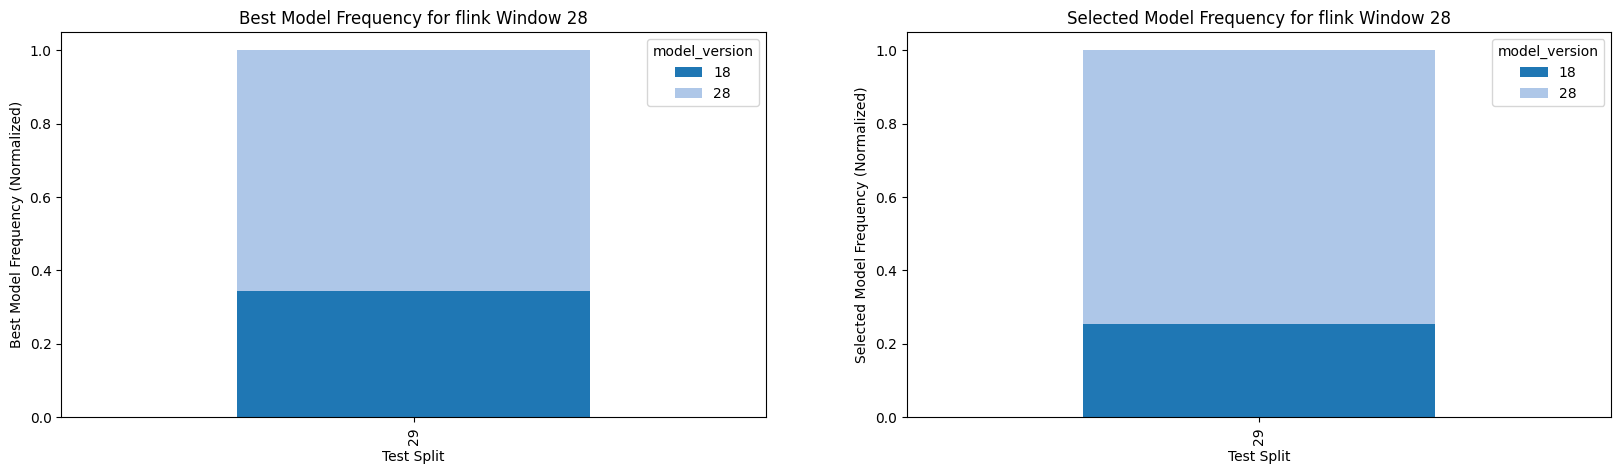

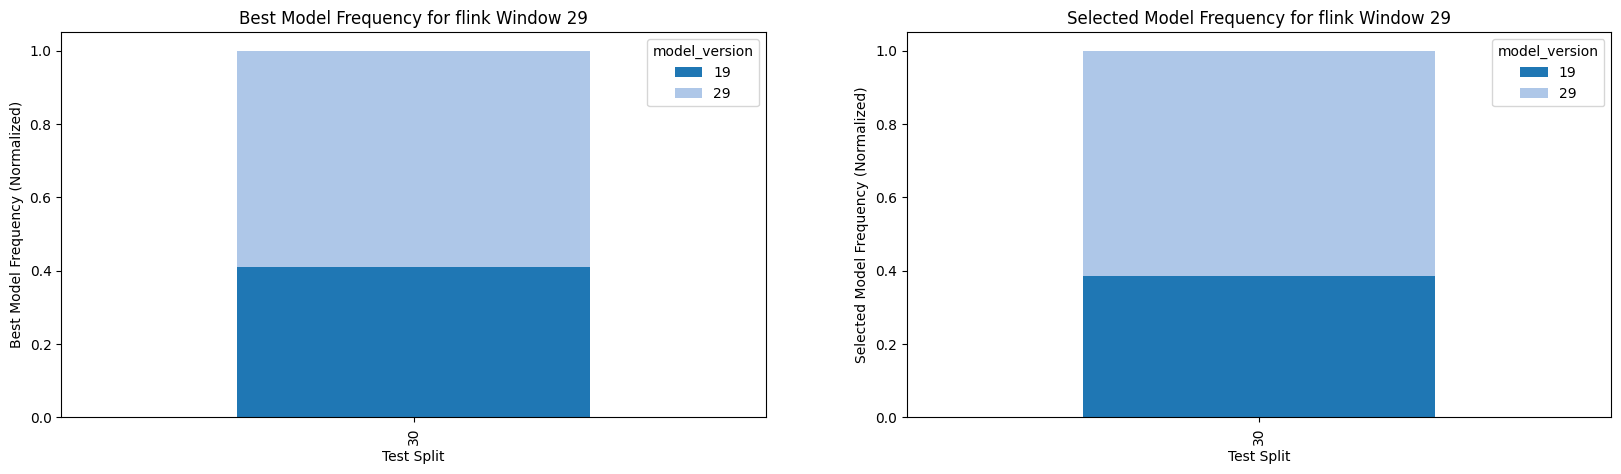

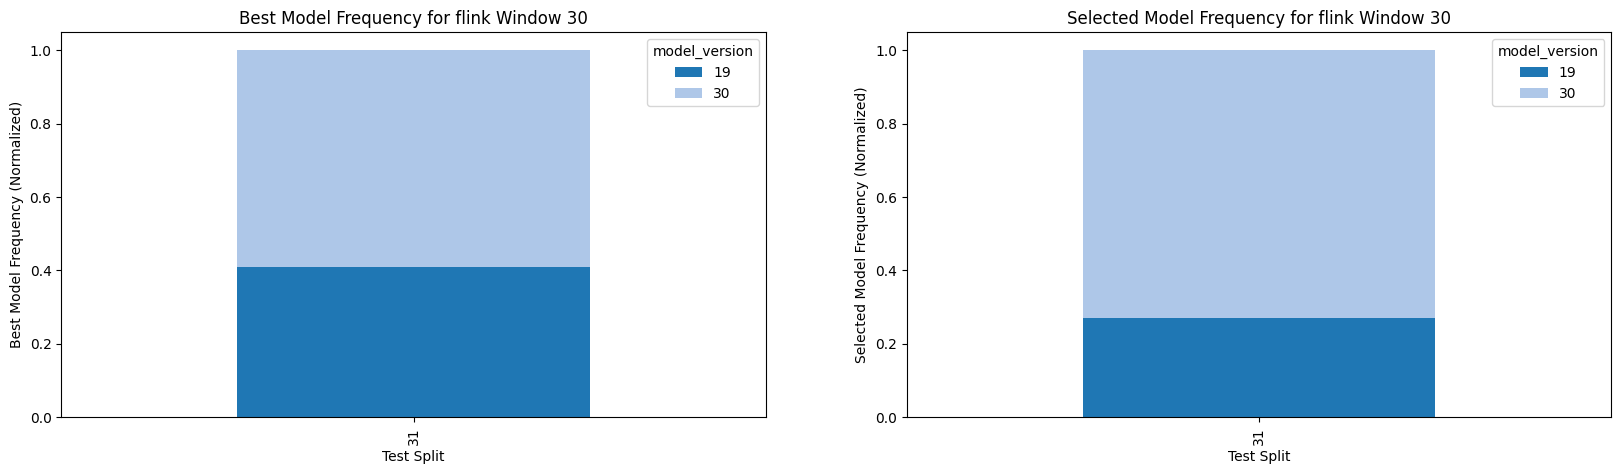

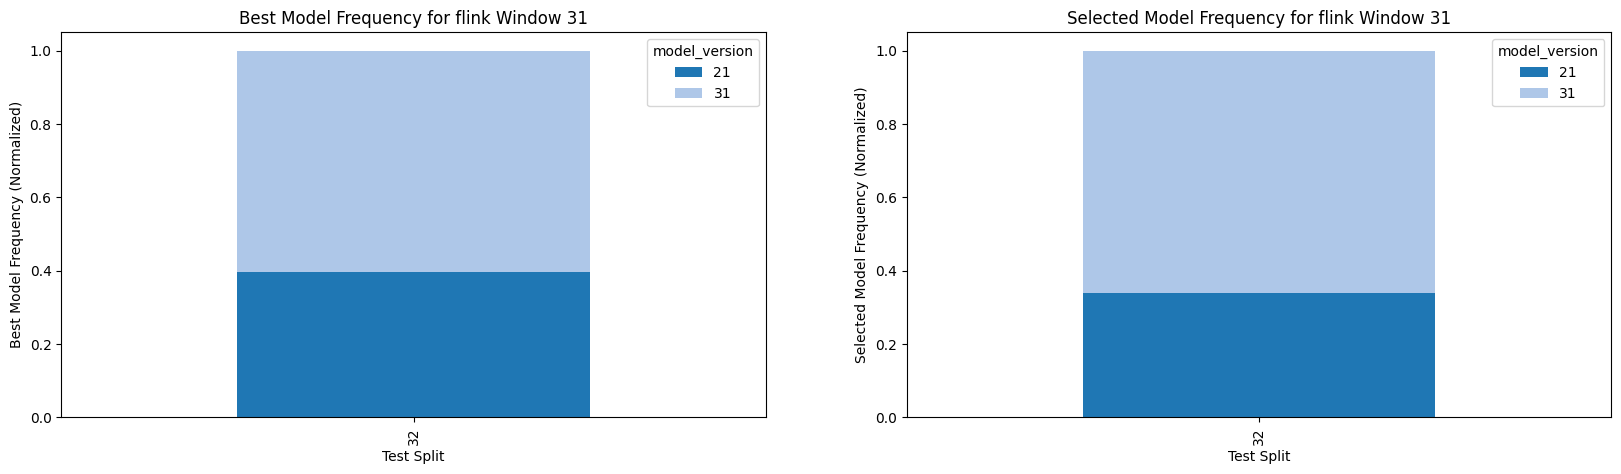

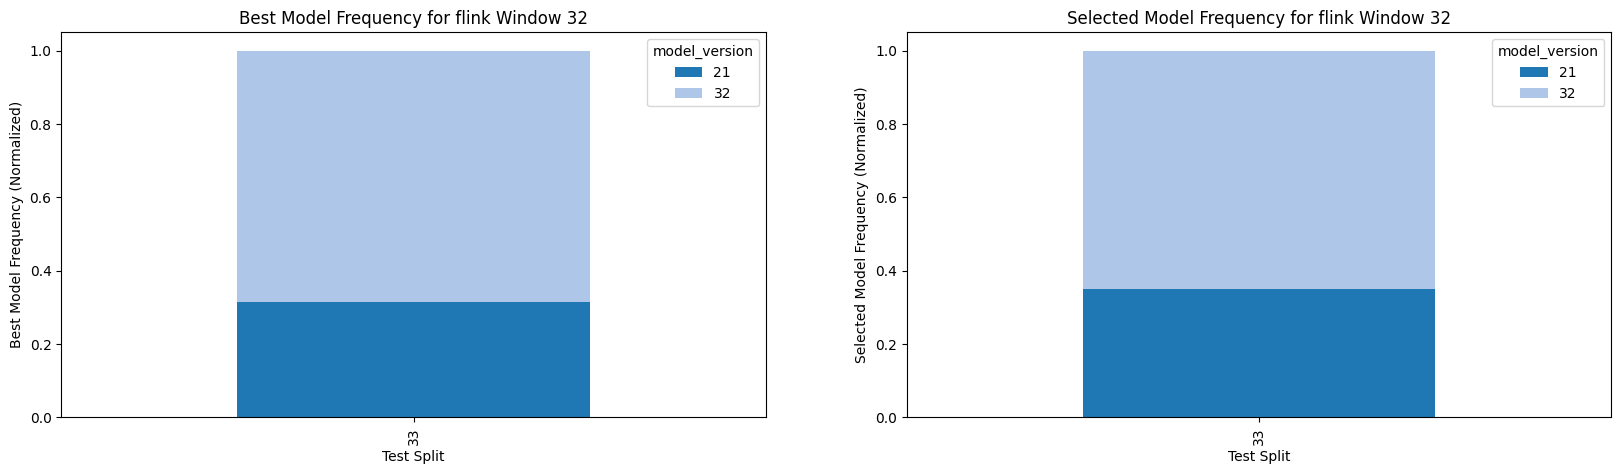

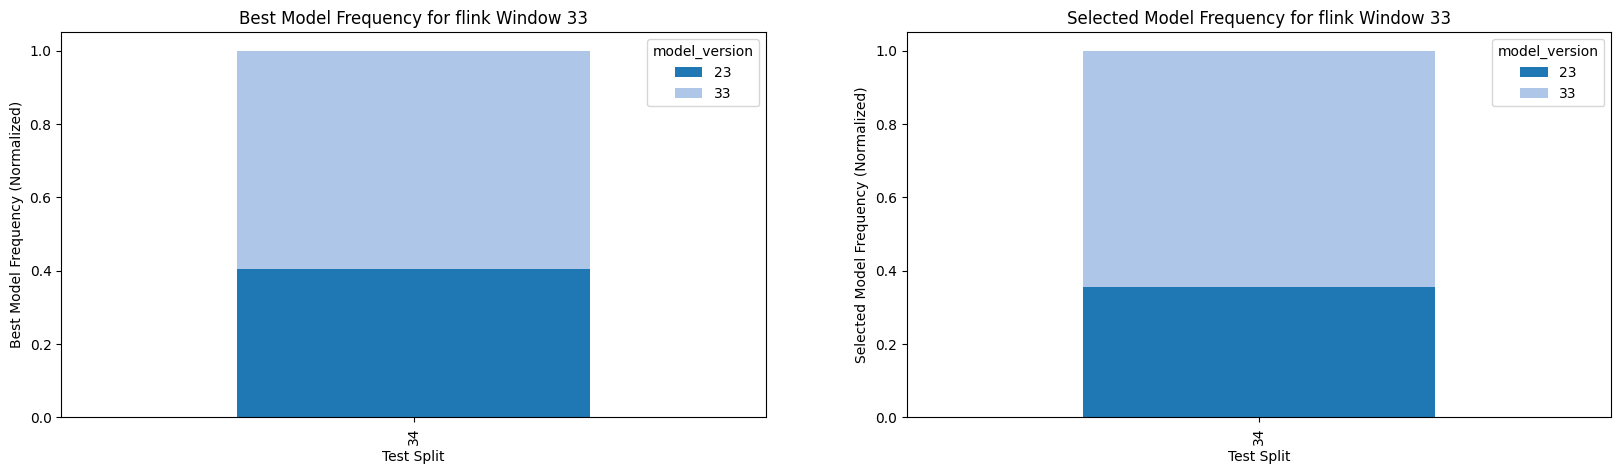

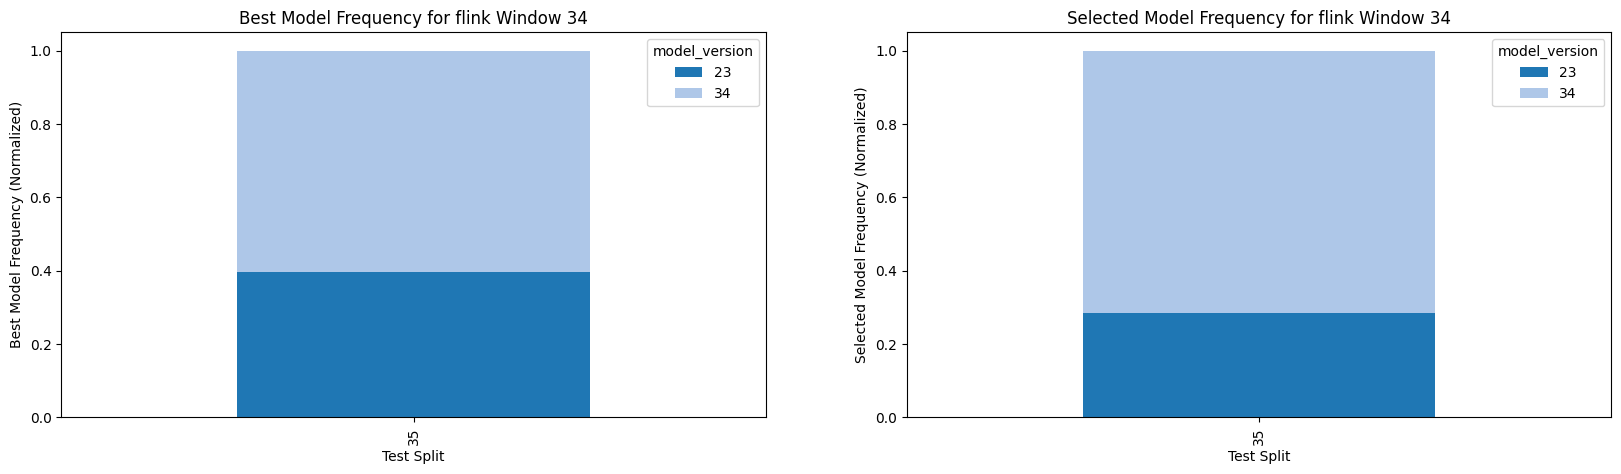

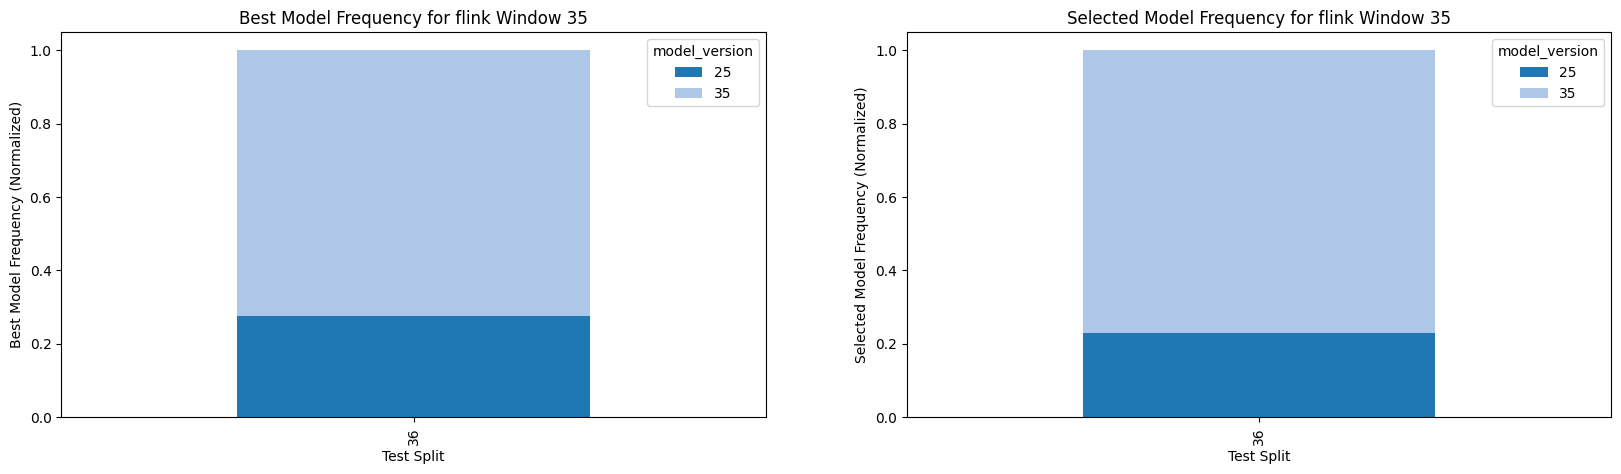

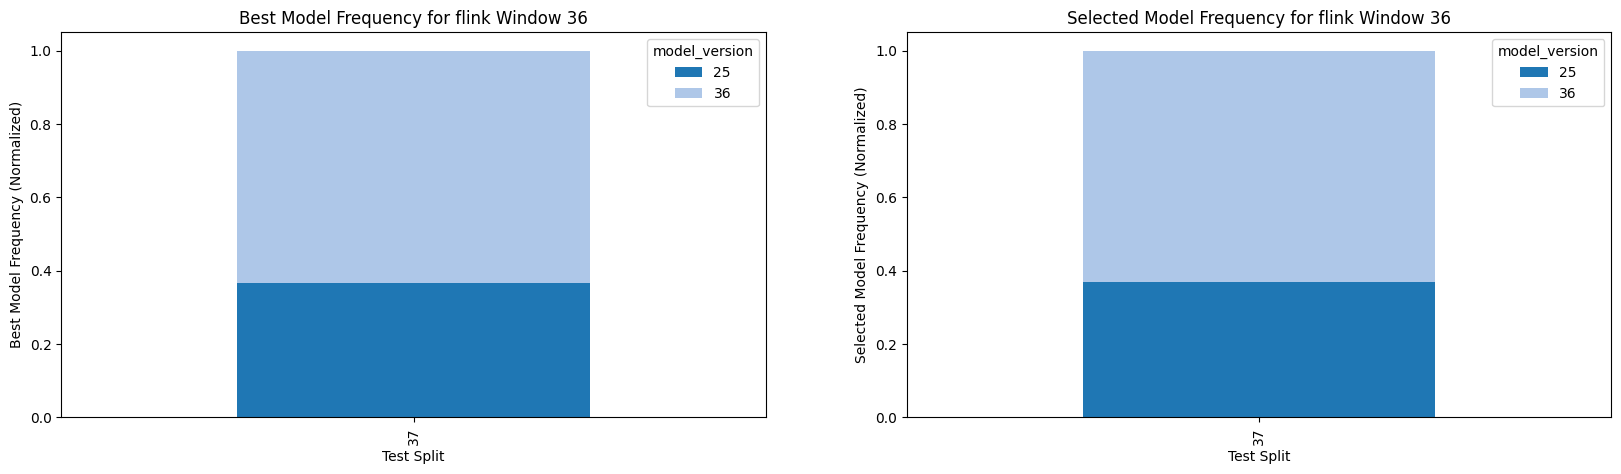

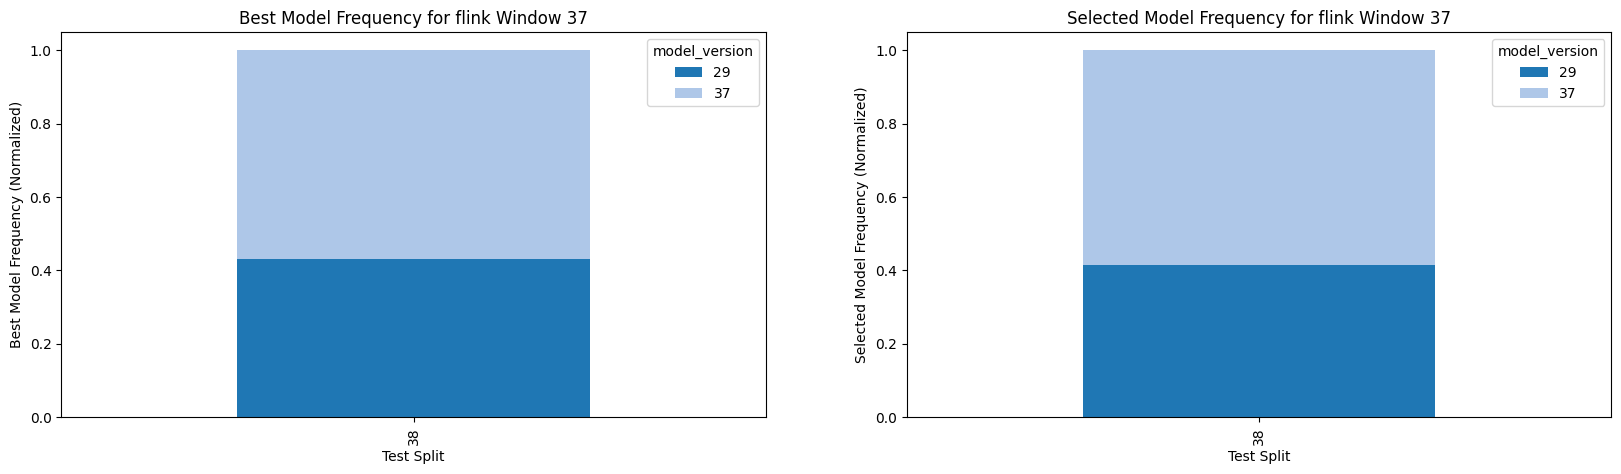

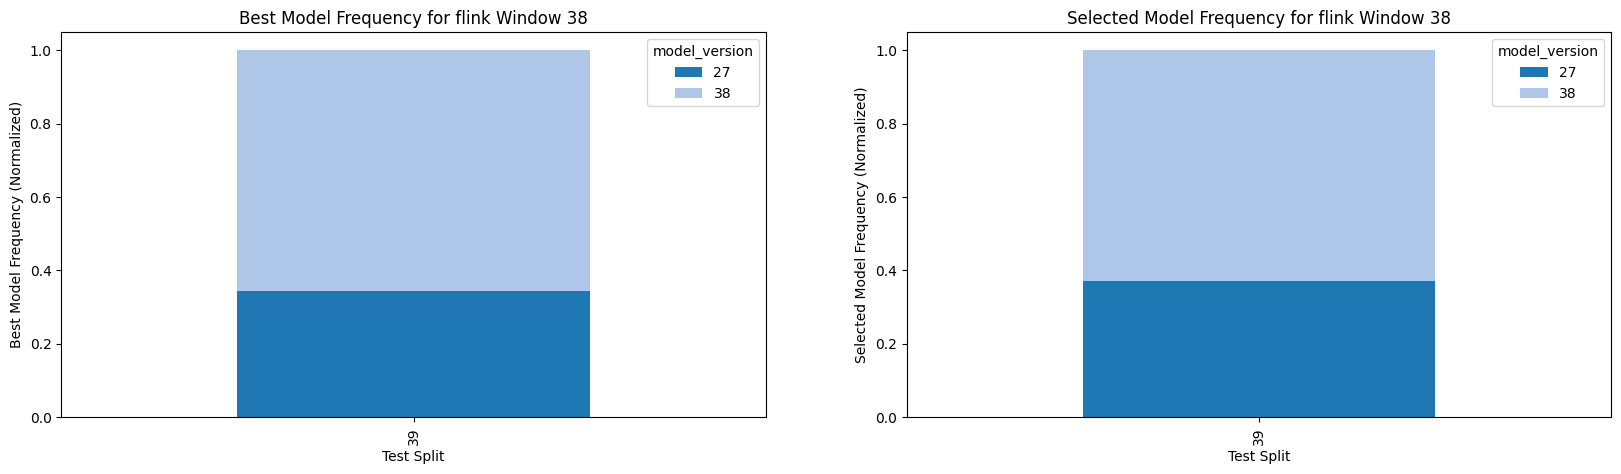

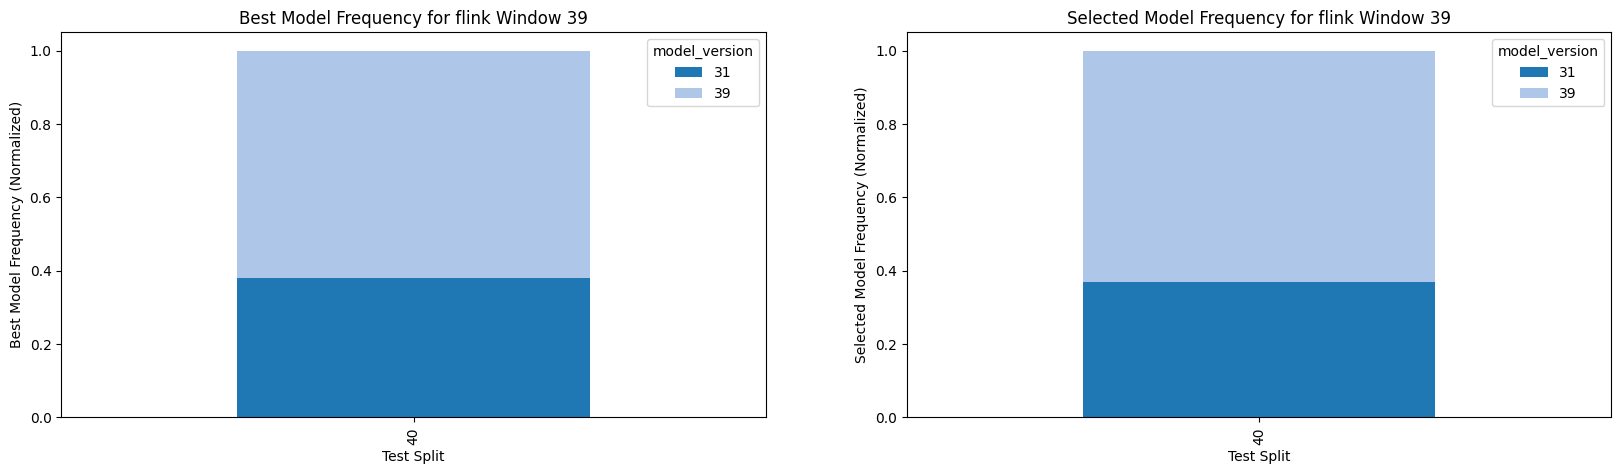

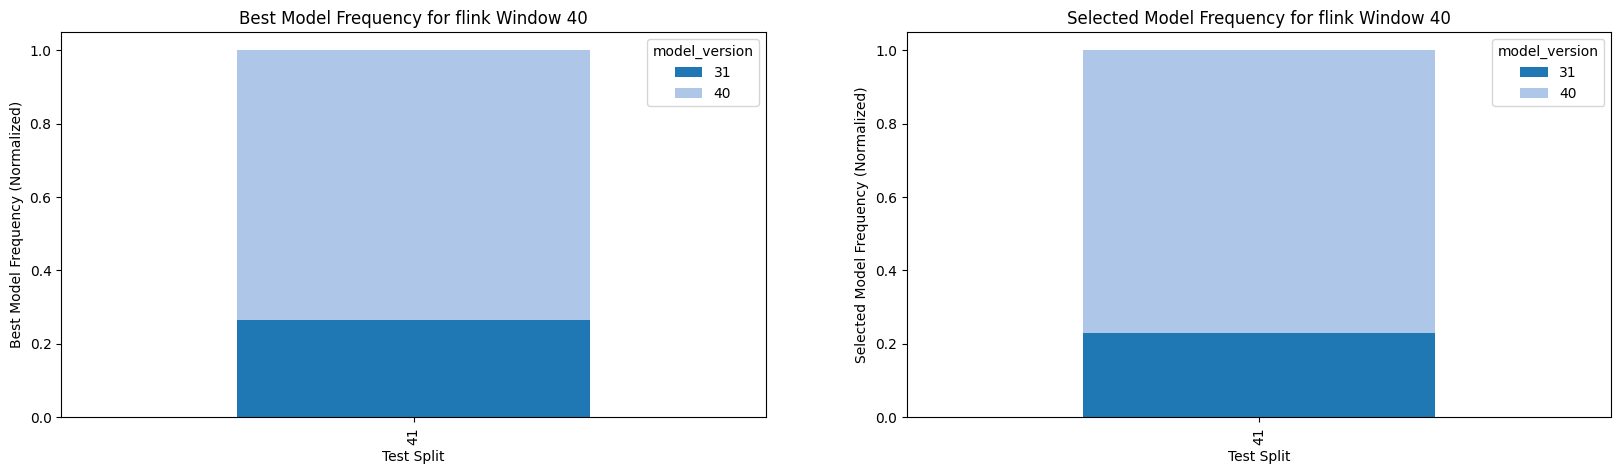

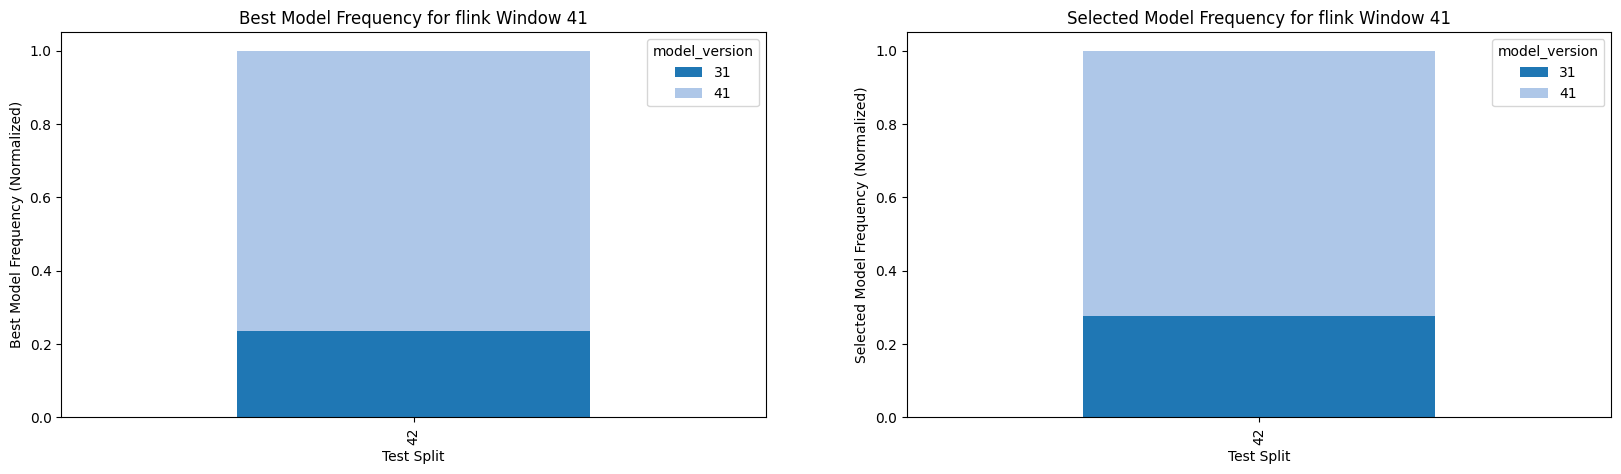

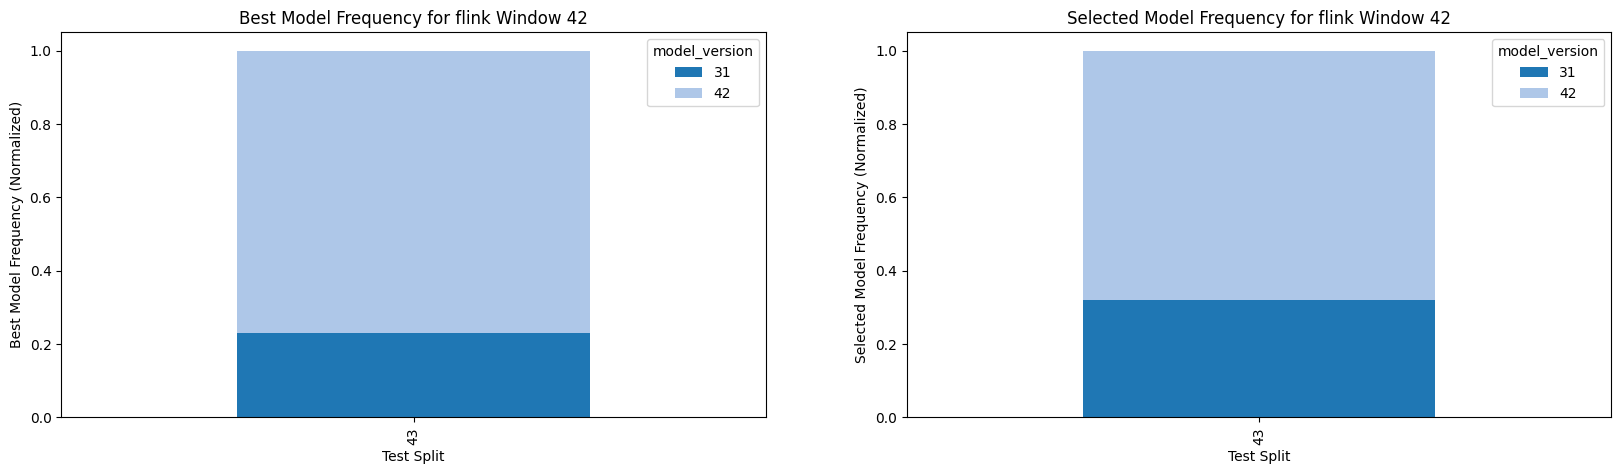

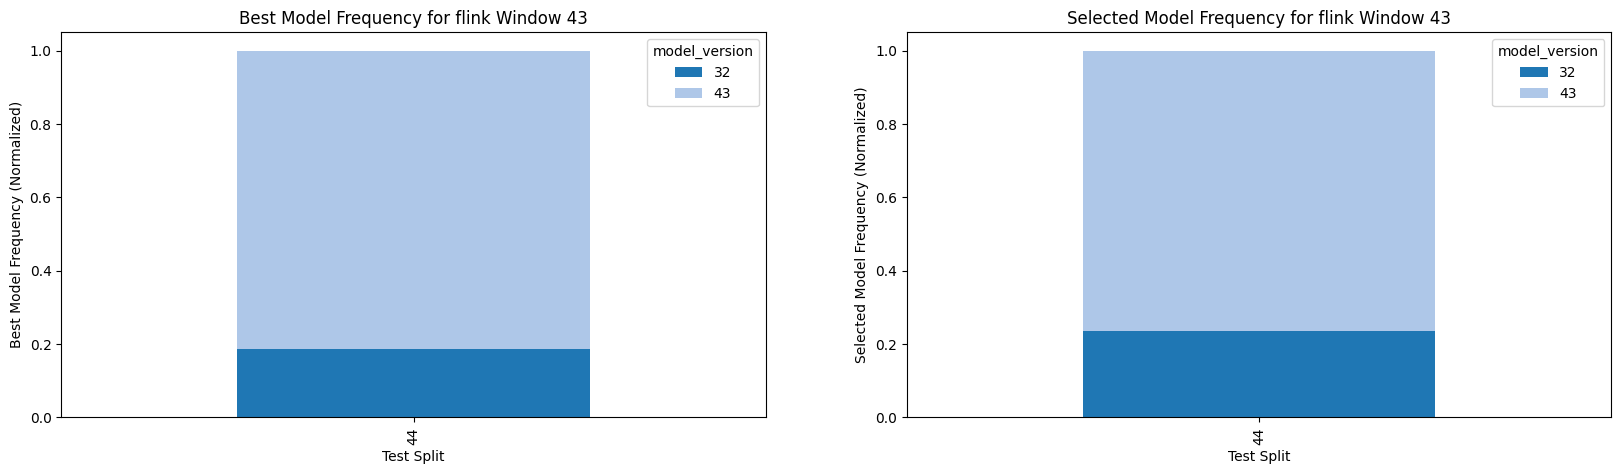

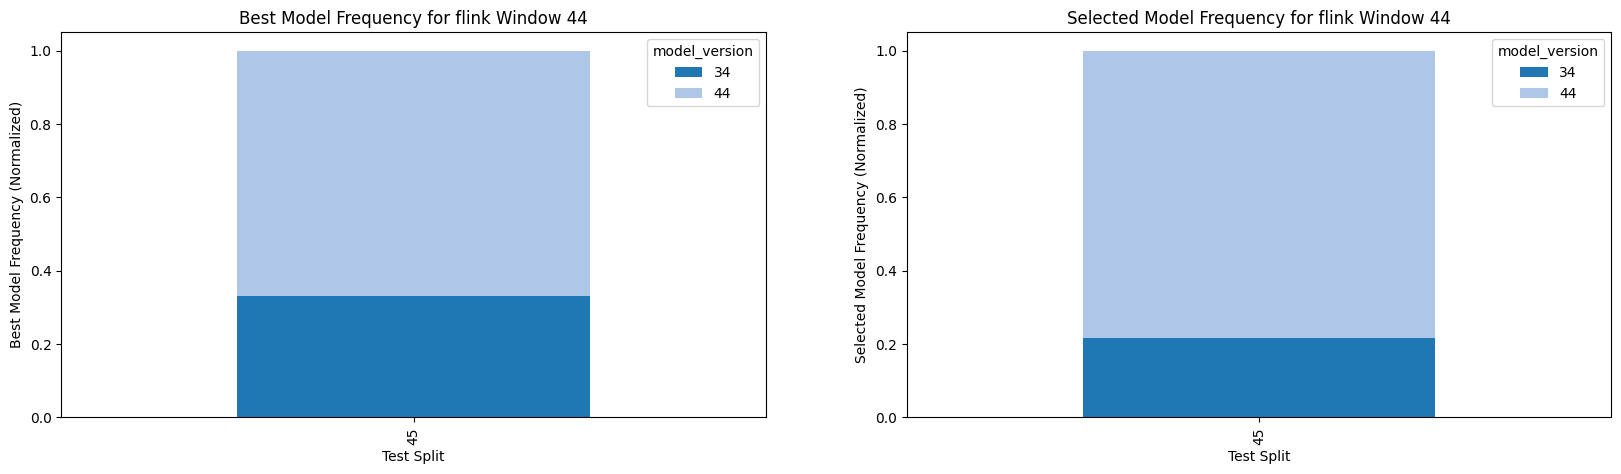

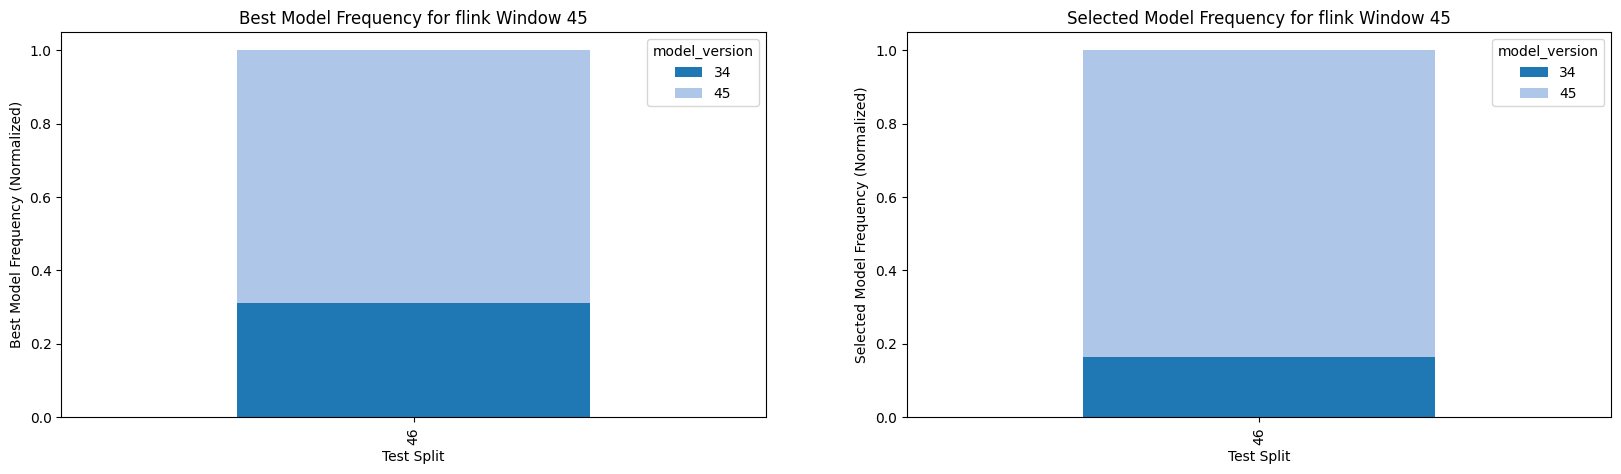

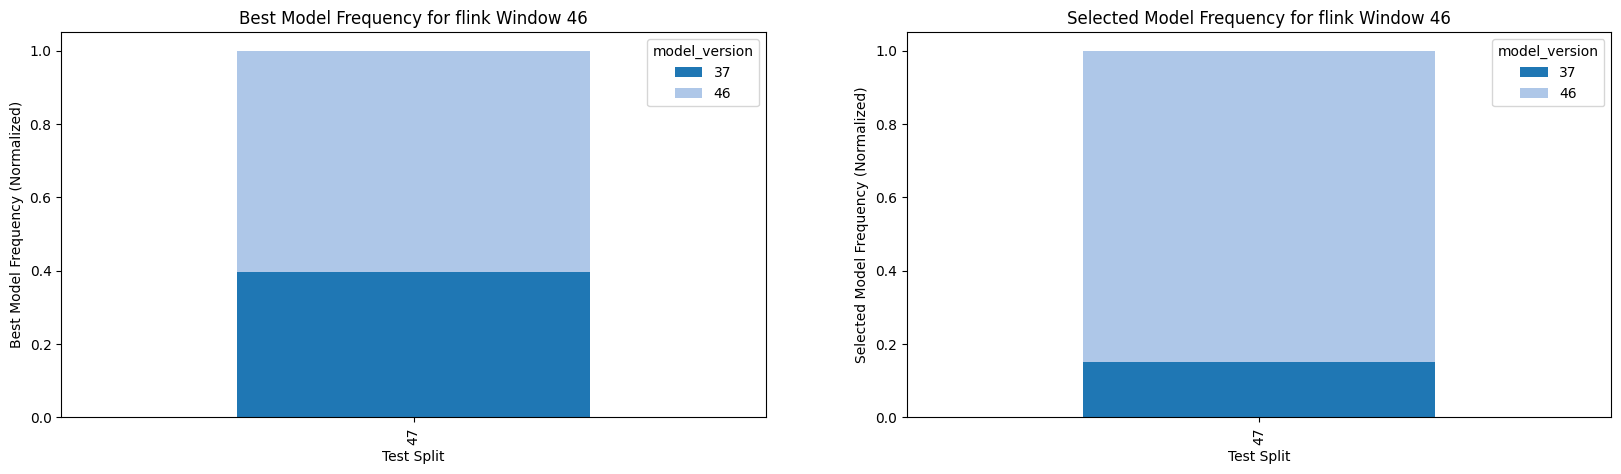

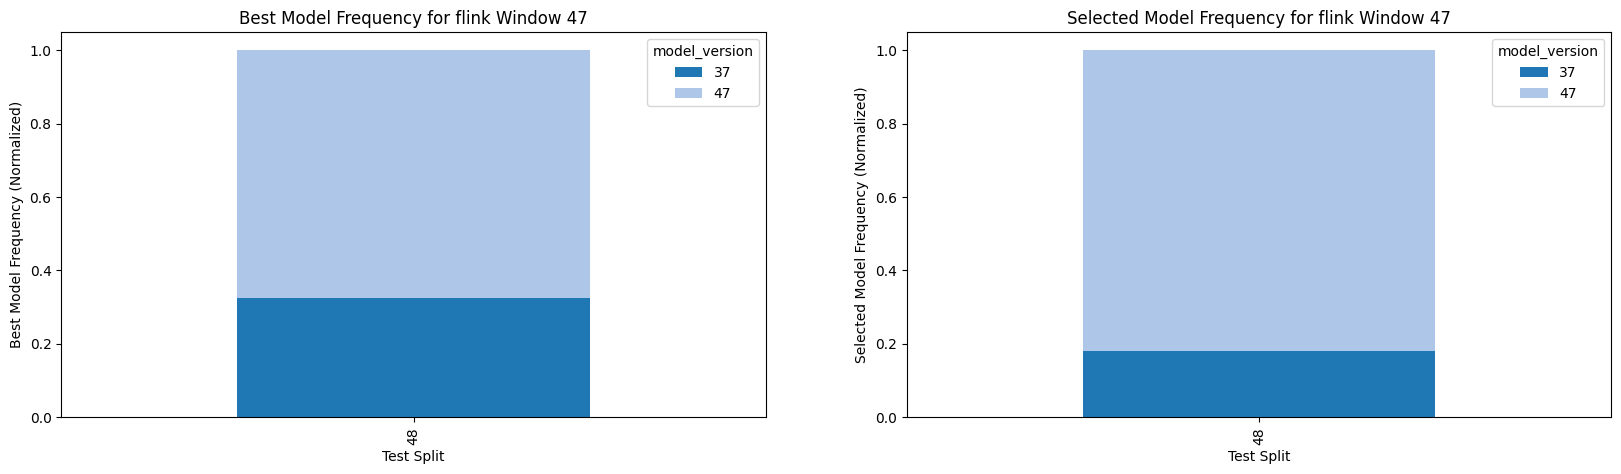

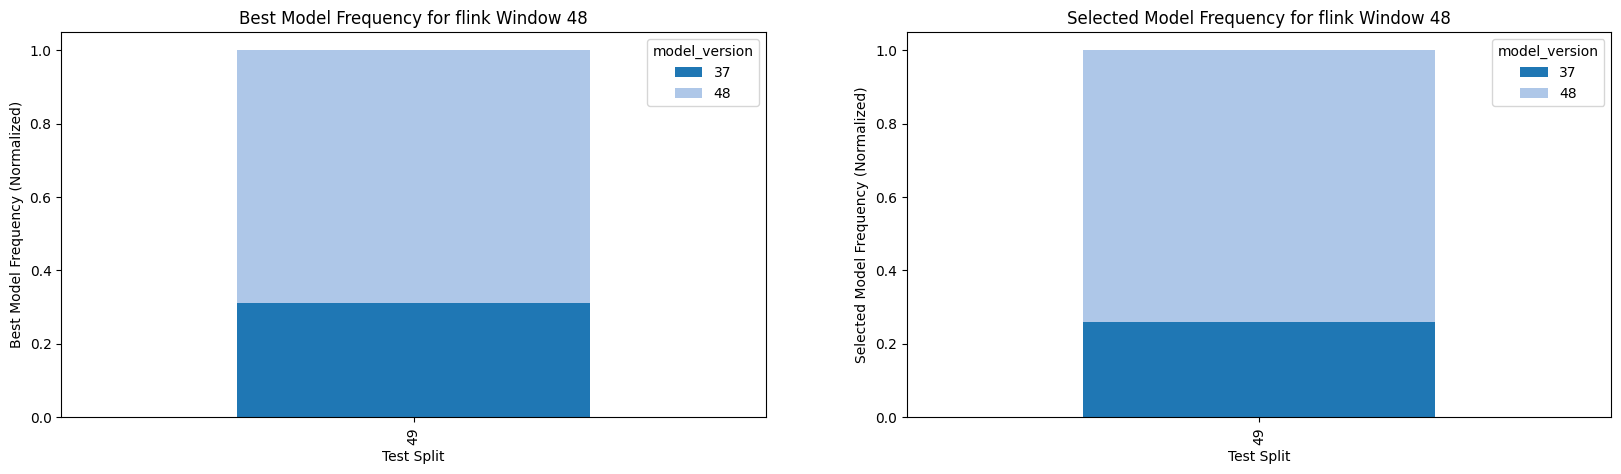

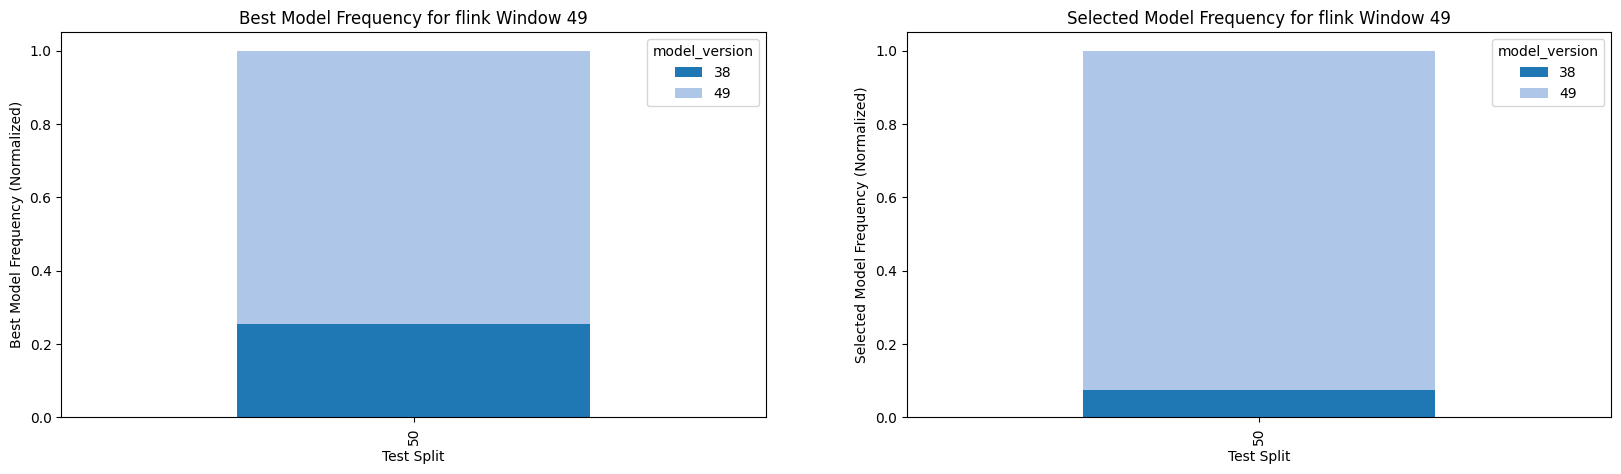

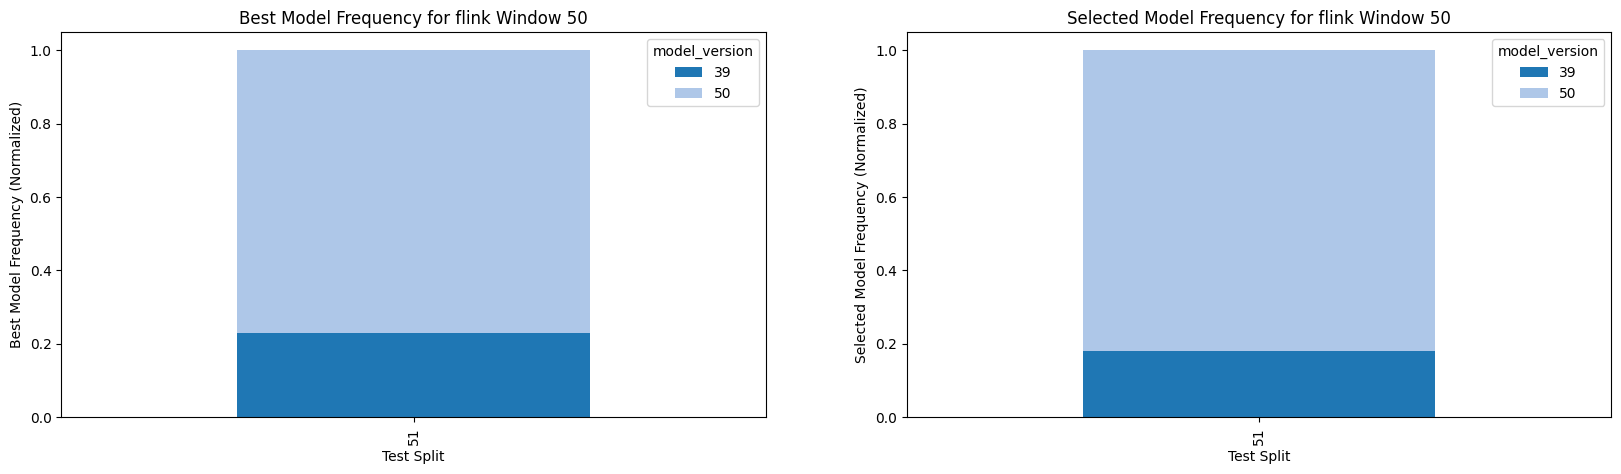

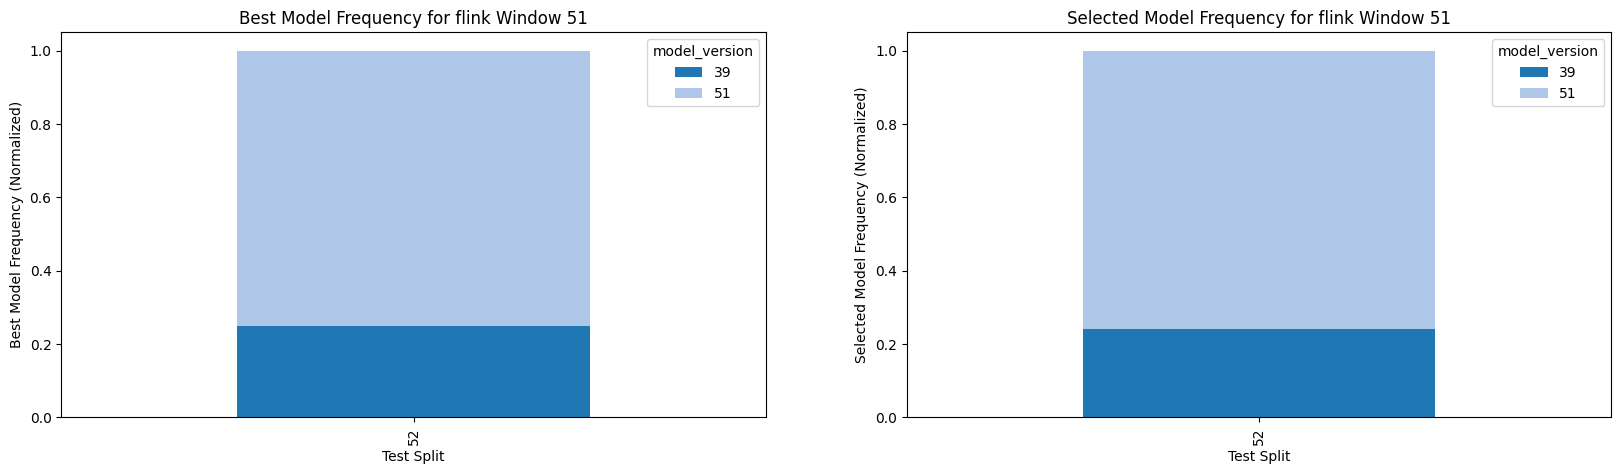

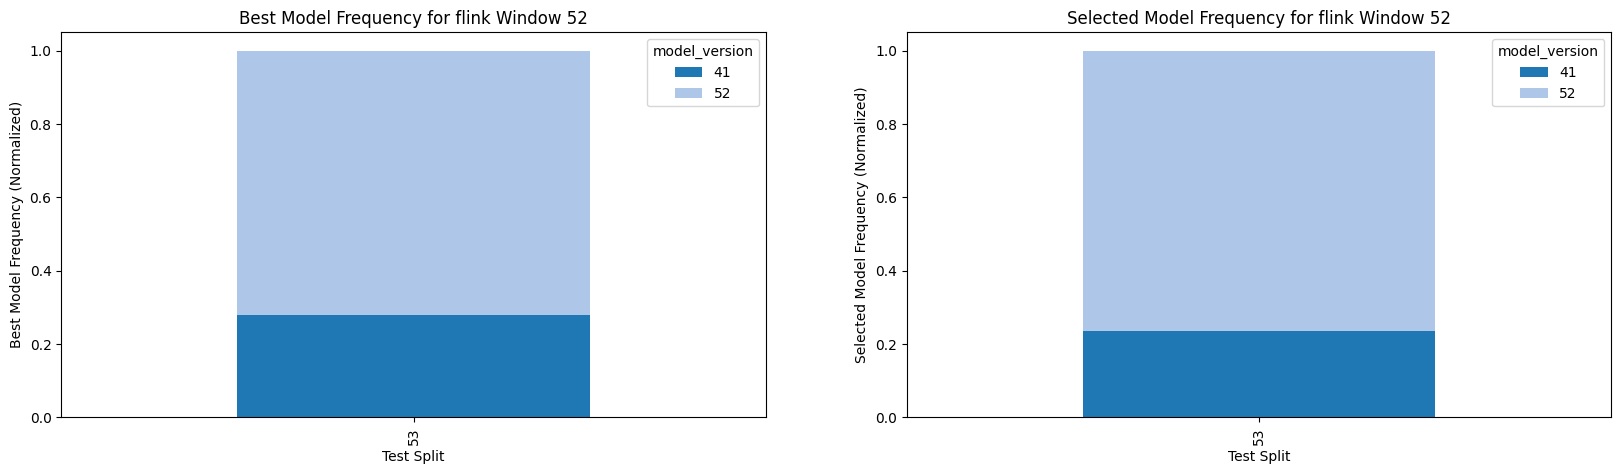

In [13]:
for i in range(MODEL_HISTORY,TOTAL_WINDOWS - 1):
    temp_selektmodel_df = selektmodel_df[selektmodel_df["window"] == i]
    temp_selektmodel_df = temp_selektmodel_df[temp_selektmodel_df["test_split"] == i + 1]
    temp_bestmodel_df = bestmodel_df[bestmodel_df["window"] == i]
    temp_bestmodel_df = temp_bestmodel_df[temp_bestmodel_df["test_split"] == i + 1]
    # plot normalized best model frequency per test split side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    # find unique models
    unique_models = set(temp_bestmodel_df["model_version"].unique()) | set(temp_selektmodel_df["model_version"].unique())
    unique_models = list(unique_models)
    unique_models.sort()

    # creating color palette
    palette_colors = sns.color_palette('tab20')
    palette_dict = {model_version: color for model_version, color in zip(unique_models, palette_colors)}

    # best model
    model_frequency_by_test_split = temp_bestmodel_df.groupby('test_split')['model_version'].value_counts().unstack().fillna(0)
    normalized_model_frequency_by_test_split = model_frequency_by_test_split.div(model_frequency_by_test_split.sum(axis=1), axis=0)
    p = normalized_model_frequency_by_test_split.plot(kind='bar', stacked=True, ax=ax1, color=palette_dict)
    p.set_xlabel("Test Split")
    p.set_ylabel("Best Model Frequency (Normalized)")
    p.set_title(f"Best Model Frequency for {PROJECT_NAME} Window {i}")
    
    # selected model
    model_frequency_by_test_split = temp_selektmodel_df.groupby('test_split')['model_version'].value_counts().unstack().fillna(0)
    normalized_model_frequency_by_test_split = model_frequency_by_test_split.div(model_frequency_by_test_split.sum(axis=1), axis=0)
    q = normalized_model_frequency_by_test_split.plot(kind='bar', stacked=True, ax=ax2, color=palette_dict)
    q.set_xlabel("Test Split")
    q.set_ylabel("Selected Model Frequency (Normalized)")
    q.set_title(f"Selected Model Frequency for {PROJECT_NAME} Window {i}")
    plt.show()